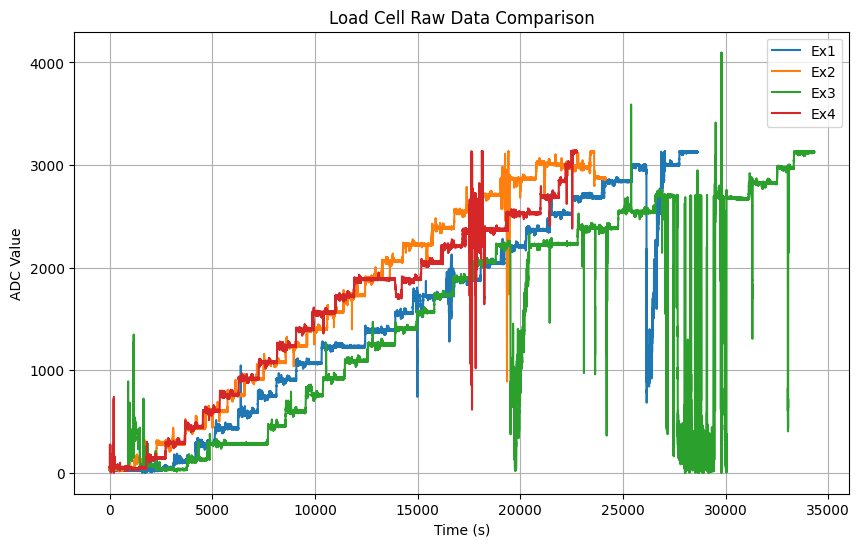

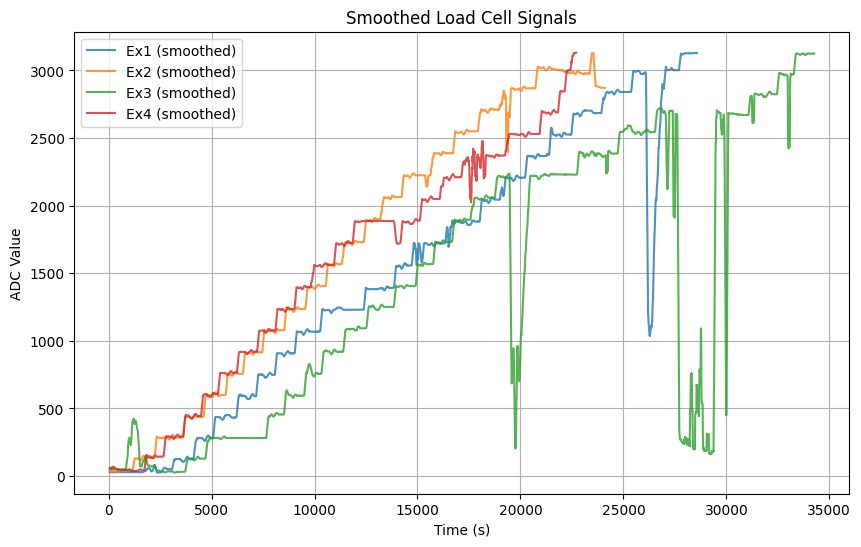

,Time,Data
count,143142.000000,143142.000000
mean,14314.099999,1512.713103
std,8264.336098,979.476064
min,0.000000,0.000000
25%,7157.000000,611.250000
50%,14314.000000,1533.000000
75%,21471.000000,2368.000000
max,28628.000000,3139.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV files
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

dataframes = [pd.read_csv(p) for p in paths]

# Basic information
summary_stats = [df.describe() for df in dataframes]

# Plot raw data
plt.figure(figsize=(10, 6))
for i, df in enumerate(dataframes, start=1):
    plt.plot(df["Time"], df["Data"], label=f"Ex{i}")
plt.title("Load Cell Raw Data Comparison")
plt.xlabel("Time (s)")
plt.ylabel("ADC Value")
plt.legend()
plt.grid(True)
plt.show()

# Apply moving average to smooth data
window = 500  # adjust window for smoothing
smoothed_data = [df["Data"].rolling(window, center=True).mean() for df in dataframes]

# Plot smoothed data only (no mean curve)
plt.figure(figsize=(10, 6))
for i, s in enumerate(smoothed_data, start=1):
    plt.plot(dataframes[i-1]["Time"], s, label=f"Ex{i} (smoothed)", alpha=0.8)
plt.title("Smoothed Load Cell Signals")
plt.xlabel("Time (s)")
plt.ylabel("ADC Value")
plt.legend()
plt.grid(True)
plt.show()

summary_stats[0]


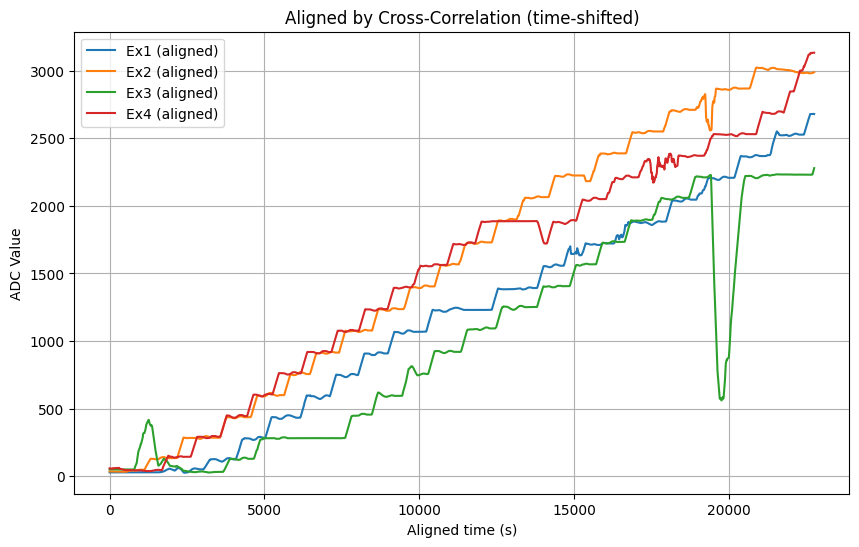

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- settings ----------
paths = ["/content/Ex1.csv","/content/Ex2.csv","/content/Ex3.csv","/content/Ex5.csv"]
WINDOW_SAMPLES = 201          # smoothing (odd number recommended)
MODE = "xcorr"                # "t0" or "xcorr"
REF = 0                       # reference series index for xcorr
N_GRID = 5000                 # common grid size for xcorr/plot
# ------------------------------

# load, sort, dedup
dfs = []
for p in paths:
    df = pd.read_csv(p).sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    # moving average
    df["Smooth"] = df["Data"].rolling(WINDOW_SAMPLES, center=True, min_periods=WINDOW_SAMPLES//2).mean()
    dfs.append(df)

if MODE == "t0":
    # ---------- align by start-at-zero ----------
    for df in dfs:
        t0 = df["Time"].iloc[0]
        df["t_aligned"] = df["Time"] - t0

    plt.figure(figsize=(10,6))
    for i, df in enumerate(dfs, start=1):
        plt.plot(df["t_aligned"], df["Smooth"], label=f"Ex{i} (smoothed)")
    plt.title("Aligned by Start Time (t = 0 at first sample)")
    plt.xlabel("Time aligned (s)")
    plt.ylabel("ADC Value")
    plt.grid(True); plt.legend(); plt.show()

else:
    # ---------- align by cross-correlation ----------
    # build a common uniform grid over the overlap
    t_min = max(df["Time"].min() for df in dfs)
    t_max = min(df["Time"].max() for df in dfs)
    if not np.isfinite(t_min) or not np.isfinite(t_max) or t_max <= t_min:
        # fallback to union range
        t_min = min(df["Time"].min() for df in dfs)
        t_max = max(df["Time"].max() for df in dfs)
    t_common = np.linspace(t_min, t_max, N_GRID)
    dt = (t_common[-1] - t_common[0]) / (len(t_common) - 1)

    # interpolate smoothed traces onto the common grid
    Y = []
    for df in dfs:
        t = df["Time"].to_numpy(float)
        y = df["Smooth"].to_numpy(float)
        m = np.isfinite(t) & np.isfinite(y)
        if m.sum() < 2:
            Y.append(np.full_like(t_common, np.nan))
        else:
            Y.append(np.interp(t_common, t[m], y[m], left=np.nan, right=np.nan))

    # z-score each trace ignoring NaNs (stabilizes xcorr)
    def zscore_nan(a):
        mu = np.nanmean(a); sd = np.nanstd(a)
        return (a - mu) / (sd if sd > 0 else 1.0)

    Yz = [zscore_nan(y) for y in Y]
    ref = Yz[REF]
    ref_f = np.nan_to_num(ref, nan=0.0)

    # compute lag that maximizes correlation vs reference
    lags = [0]
    for k in range(1, len(Yz)):
        y = np.nan_to_num(Yz[k], nan=0.0)
        c = np.correlate(y, ref_f, mode="full")  # length 2N-1
        lag_idx = np.argmax(c) - (len(ref_f) - 1)  # samples
        lags.append(lag_idx)

    # apply time shifts: positive lag => series occurs later => shift left in time
    t_aligned = []
    for lag in lags:
        t_aligned.append(t_common - lag * dt)

    # plot aligned curves
    plt.figure(figsize=(10,6))
    for i, (t_a, y) in enumerate(zip(t_aligned, Y), start=1):
        plt.plot(t_a - t_aligned[REF][0], y, label=f"Ex{i} (aligned)")  # normalize display so ref starts near 0
    plt.title("Aligned by Cross-Correlation (time-shifted)")
    plt.xlabel("Aligned time (s)")
    plt.ylabel("ADC Value")
    plt.grid(True); plt.legend(); plt.show()


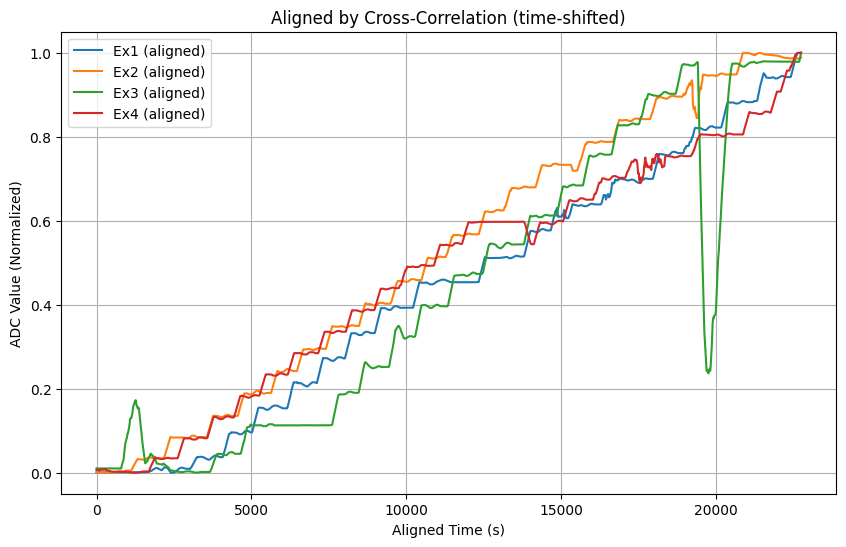

✅ Aligned data exported to: /content/aligned_data.csv
Computed lags (samples): [0, np.int64(0), np.int64(0), np.int64(0)]
Lag offsets (seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# SETTINGS
# ====================================================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

WINDOW_SAMPLES = 201     # smoothing window (odd number recommended)
MODE = "xcorr"           # "t0" (simple start alignment) or "xcorr" (auto time shift)
REF = 0                  # reference series index for cross-correlation
N_GRID = 5000            # number of points for common time grid interpolation
NORMALIZE = True         # normalize curves (0–1)
EXPORT_ALIGNED = True    # export aligned data to CSV
EXPORT_PATH = "/content/aligned_data.csv"
# ====================================================


# ----------------------------------------------------
# Load and smooth data
# ----------------------------------------------------
dfs = []
for path in paths:
    df = pd.read_csv(path).sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    df["Smooth"] = df["Data"].rolling(WINDOW_SAMPLES, center=True, min_periods=WINDOW_SAMPLES // 2).mean()
    dfs.append(df)

# ----------------------------------------------------
# Simple t0 alignment
# ----------------------------------------------------
if MODE == "t0":
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs, start=1):
        t0 = df["Time"].iloc[0]
        df["t_aligned"] = df["Time"] - t0
        y = df["Smooth"]
        if NORMALIZE:
            y = (y - y.min()) / (y.max() - y.min())
        plt.plot(df["t_aligned"], y, label=f"Ex{i} (smoothed)")
    plt.title("Aligned by Start Time (t = 0 at first sample)")
    plt.xlabel("Time aligned (s)")
    plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
    plt.legend()
    plt.grid(True)
    plt.show()


# ----------------------------------------------------
# Cross-correlation alignment
# ----------------------------------------------------
else:
    # common time grid (use intersection if possible)
    t_min = max(df["Time"].min() for df in dfs)
    t_max = min(df["Time"].max() for df in dfs)
    if not np.isfinite(t_min) or not np.isfinite(t_max) or t_max <= t_min:
        t_min = min(df["Time"].min() for df in dfs)
        t_max = max(df["Time"].max() for df in dfs)
    t_common = np.linspace(t_min, t_max, N_GRID)
    dt = (t_common[-1] - t_common[0]) / (len(t_common) - 1)

    # interpolate smoothed signals
    interp_signals = []
    for df in dfs:
        t, y = df["Time"].to_numpy(float), df["Smooth"].to_numpy(float)
        mask = np.isfinite(t) & np.isfinite(y)
        if mask.sum() < 2:
            interp_signals.append(np.full_like(t_common, np.nan))
        else:
            interp_signals.append(np.interp(t_common, t[mask], y[mask], left=np.nan, right=np.nan))

    # z-score for cross-correlation
    def zscore_nan(a):
        mu, sd = np.nanmean(a), np.nanstd(a)
        return (a - mu) / (sd if sd > 0 else 1.0)

    signals_z = [zscore_nan(y) for y in interp_signals]
    ref = np.nan_to_num(signals_z[REF], nan=0.0)

    # compute lags by cross-correlation
    lags = [0]
    for i, y in enumerate(signals_z[1:], start=1):
        y_filled = np.nan_to_num(y, nan=0.0)
        corr = np.correlate(y_filled, ref, mode="full")
        lag_idx = np.argmax(corr) - (len(ref) - 1)
        lags.append(lag_idx)

    # apply time shifts
    t_aligned = [t_common - lag * dt for lag in lags]

    # normalize (optional)
    if NORMALIZE:
        interp_signals = [(y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y)) for y in interp_signals]

    # ----------------------------------------------------
    # Plot aligned results
    # ----------------------------------------------------
    plt.figure(figsize=(10, 6))
    for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
        plt.plot(t_a - t_aligned[REF][0], y, label=f"Ex{i} (aligned)")
    plt.title("Aligned by Cross-Correlation (time-shifted)")
    plt.xlabel("Aligned Time (s)")
    plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------------------------------
    # Export aligned data (optional)
    # ----------------------------------------------------
    if EXPORT_ALIGNED:
        aligned_df = pd.DataFrame({"Time": t_aligned[REF] - t_aligned[REF][0]})
        for i, y in enumerate(interp_signals, start=1):
            aligned_df[f"Ex{i}"] = y
        aligned_df.to_csv(EXPORT_PATH, index=False)
        print(f"✅ Aligned data exported to: {EXPORT_PATH}")

    # ----------------------------------------------------
    # Diagnostics
    # ----------------------------------------------------
    print("Computed lags (samples):", lags)
    print("Lag offsets (seconds):", [lag * dt for lag in lags])


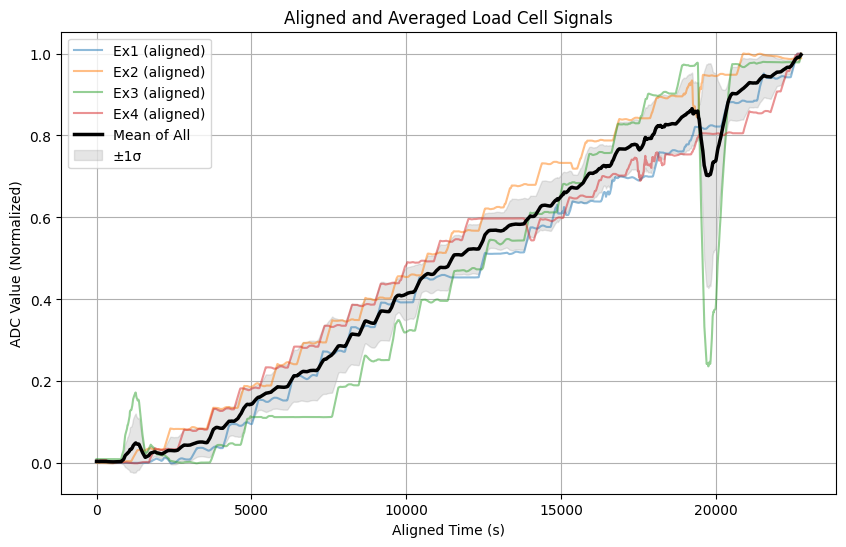

In [ ]:
# --- compute mean across all aligned normalized traces ---
stacked = np.vstack(interp_signals)               # shape: (n_signals, n_points)
mean_curve = np.nanmean(stacked, axis=0)          # average ignoring NaN
std_curve  = np.nanstd(stacked, axis=0)           # optional: standard deviation

# --- plot with mean curve ---
plt.figure(figsize=(10,6))
for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
    plt.plot(t_a - t_aligned[REF][0], y, alpha=0.5, label=f"Ex{i} (aligned)")

plt.plot(
    t_aligned[REF] - t_aligned[REF][0],
    mean_curve,
    color="black", linewidth=2.5, label="Mean of All"
)

# optional: shaded ±1σ region
plt.fill_between(
    t_aligned[REF] - t_aligned[REF][0],
    mean_curve - std_curve,
    mean_curve + std_curve,
    color="gray", alpha=0.2, label="±1σ"
)

plt.title("Aligned and Averaged Load Cell Signals")
plt.xlabel("Aligned Time (s)")
plt.ylabel("ADC Value (Normalized)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
stacked = np.vstack(interp_signals)              # (n_runs, n_points)
mean_curve = np.nanmedian(stacked, axis=0)       # replace nanmean
std_curve  = 1.4826*np.nanmedian(np.abs(stacked - mean_curve), axis=0)  # robust ±1σ via MAD


In [ ]:
for i, y in enumerate(interp_signals):
    # rolling median difference
    diff = np.abs(np.diff(y, prepend=y[0]))
    mad = np.nanmedian(diff)
    clip_thr = 6 * mad                    # adjust multiplier (5–8 typical)
    y_clipped = np.clip(y, np.nanmin(y), np.nanpercentile(y, 99.5))
    jump_mask = diff > clip_thr
    y_clipped[jump_mask] = np.nan         # mark large jumps as NaN
    interp_signals[i] = pd.Series(y_clipped).interpolate().to_numpy()


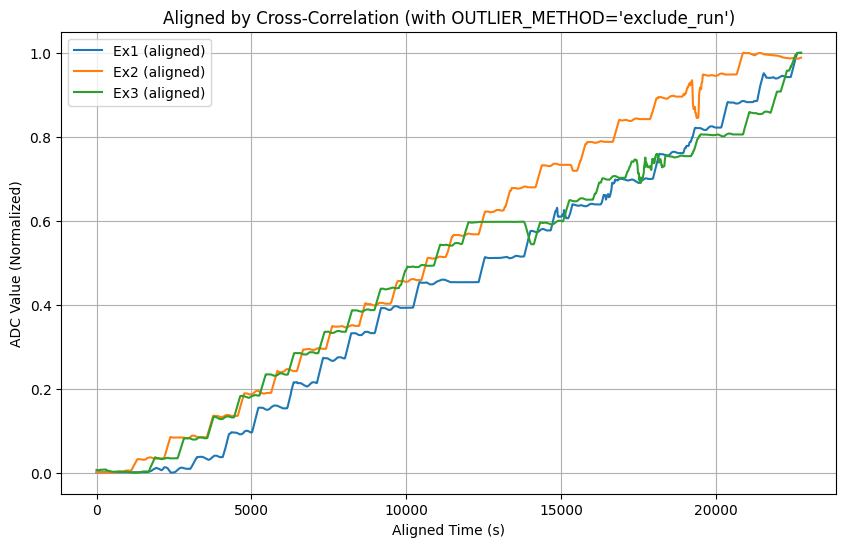

✅ Aligned data exported to: /content/aligned_data.csv
Computed lags (samples): [0, np.int64(0), np.int64(0), np.int64(0)]
Lag offsets (seconds): [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


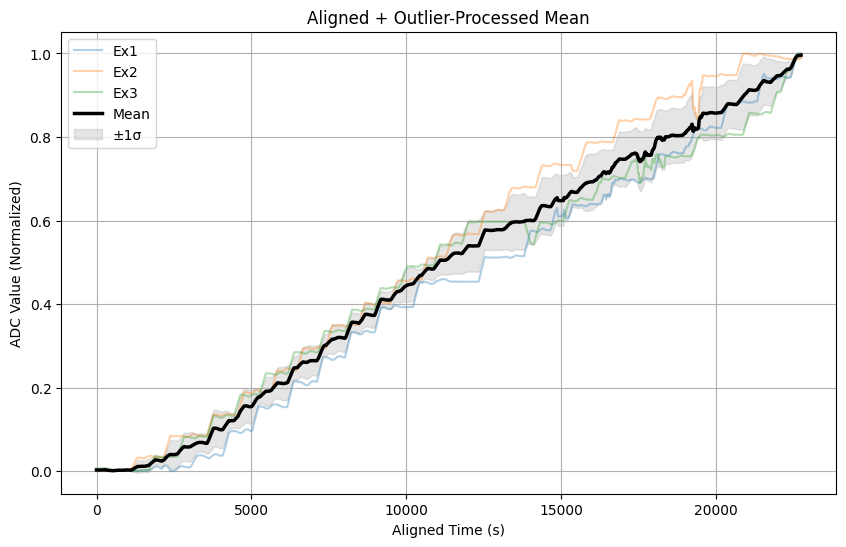

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# SETTINGS
# ====================================================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

WINDOW_SAMPLES = 201     # smoothing window (odd number recommended)
MODE = "xcorr"           # "t0" or "xcorr"
REF = 0                  # reference series index for cross-correlation
N_GRID = 5000            # common time grid points
NORMALIZE = True         # normalize each run to 0–1
EXPORT_ALIGNED = True
EXPORT_PATH = "/content/aligned_data.csv"

# ---- Outlier handling (choose one) ------------------
OUTLIER_METHOD = "exclude_run"   # "none", "clip", "mad", "exclude_run"
# 'clip' params:
CLIP_JUMP_MULT = 6.0     # threshold = MULT * MAD of first-difference
CLIP_PCTL_CAP   = 99.5   # soft cap for extreme high values, in percentile
# 'mad' params (per-time robust z):
MAD_Z_MAX       = 3.0    # keep points with |z| <= this
# 'exclude_run' param:
EXCLUDE_INDEX   = 2      # 0-based, e.g., 2 to drop Ex3 entirely
# ====================================================


# ----------------------------------------------------
# Load and smooth data
# ----------------------------------------------------
dfs = []
for path in paths:
    df = pd.read_csv(path).sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    df["Smooth"] = df["Data"].rolling(WINDOW_SAMPLES, center=True, min_periods=WINDOW_SAMPLES // 2).mean()
    dfs.append(df)

# ----------------------------------------------------
# Simple t0 alignment
# ----------------------------------------------------
if MODE == "t0":
    t_aligned = []
    interp_signals = []

    for df in dfs:
        t0 = df["Time"].iloc[0]
        t = df["Time"] - t0
        y = df["Smooth"].to_numpy(dtype=float)
        if NORMALIZE:
            y = (y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y))
        t_aligned.append(t.to_numpy(dtype=float))
        interp_signals.append(y)

else:
    # ---------- cross-correlation alignment ----------
    # common time grid (intersection if possible; else union)
    t_min = max(df["Time"].min() for df in dfs)
    t_max = min(df["Time"].max() for df in dfs)
    if not np.isfinite(t_min) or not np.isfinite(t_max) or t_max <= t_min:
        t_min = min(df["Time"].min() for df in dfs)
        t_max = max(df["Time"].max() for df in dfs)
    t_common = np.linspace(t_min, t_max, N_GRID)
    dt = (t_common[-1] - t_common[0]) / (len(t_common) - 1)

    # interpolate smoothed signals onto the common grid
    interp_signals = []
    for df in dfs:
        t, y = df["Time"].to_numpy(float), df["Smooth"].to_numpy(float)
        mask = np.isfinite(t) & np.isfinite(y)
        if mask.sum() < 2:
            interp_signals.append(np.full_like(t_common, np.nan))
        else:
            interp_signals.append(np.interp(t_common, t[mask], y[mask], left=np.nan, right=np.nan))

    # z-score for xcorr
    def zscore_nan(a):
        mu, sd = np.nanmean(a), np.nanstd(a)
        return (a - mu) / (sd if sd > 0 else 1.0)

    signals_z = [zscore_nan(y) for y in interp_signals]
    ref = np.nan_to_num(signals_z[REF], nan=0.0)

    # compute lags vs reference
    lags = [0]
    for y in signals_z[1:]:
        y_filled = np.nan_to_num(y, nan=0.0)
        corr = np.correlate(y_filled, ref, mode="full")
        lag_idx = np.argmax(corr) - (len(ref) - 1)
        lags.append(lag_idx)

    # time shift
    t_aligned = [t_common - lag * dt for lag in lags]

    # normalize
    if NORMALIZE:
        interp_signals = [(y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y)) for y in interp_signals]

# ---------------- OUTLIER HANDLING -------------------
def clip_outliers_series(y, jump_mult=CLIP_JUMP_MULT, pctl_cap=CLIP_PCTL_CAP):
    y = y.copy()
    # soft cap very high values
    cap = np.nanpercentile(y, pctl_cap)
    y = np.minimum(y, cap)

    # mark very large jumps (relative to rolling MAD of diff)
    dy = np.abs(np.diff(y, prepend=y[0]))
    mad = np.nanmedian(dy)
    thr = jump_mult * (mad if mad > 0 else np.nanmedian(dy[dy>0]) if np.any(dy>0) else 0)
    if thr and np.isfinite(thr) and thr > 0:
        jump_mask = dy > thr
        y[jump_mask] = np.nan
        # light interpolation to fill small gaps
        y = pd.Series(y).interpolate(limit_direction="both").to_numpy()
    return y

if OUTLIER_METHOD == "clip":
    interp_signals = [clip_outliers_series(y) for y in interp_signals]

elif OUTLIER_METHOD == "mad":
    # per-time robust z across runs
    stacked = np.vstack(interp_signals)
    med = np.nanmedian(stacked, axis=0)
    mad = np.nanmedian(np.abs(stacked - med), axis=0)
    mad[mad == 0] = np.nan
    z = np.abs(stacked - med) / (1.4826 * mad)
    mask = z <= MAD_Z_MAX
    stacked_filtered = np.where(mask, stacked, np.nan)
    interp_signals = [stacked_filtered[i] for i in range(stacked.shape[0])]

elif OUTLIER_METHOD == "exclude_run":
    bad = EXCLUDE_INDEX
    if 0 <= bad < len(interp_signals):
        interp_signals.pop(bad)
        t_aligned.pop(bad)

# ----------------------------------------------------
# Plot aligned (after outlier handling)
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
    plt.plot(t_a - t_aligned[0][0], y, label=f"Ex{i} (aligned)")
plt.title(f"Aligned by {'Cross-Correlation' if MODE=='xcorr' else 'Start'} (with OUTLIER_METHOD='{OUTLIER_METHOD}')")
plt.xlabel("Aligned Time (s)")
plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------
# Export aligned data (optional)
# ----------------------------------------------------
if EXPORT_ALIGNED:
    aligned_df = pd.DataFrame({"Time": t_aligned[REF] - t_aligned[REF][0]})
    for i, y in enumerate(interp_signals, start=1):
        aligned_df[f"Ex{i}"] = y
    aligned_df.to_csv(EXPORT_PATH, index=False)
    print(f"✅ Aligned data exported to: {EXPORT_PATH}")

# ----------------------------------------------------
# Diagnostics + Mean curve (optional)
# ----------------------------------------------------
if MODE == "xcorr":
    print("Computed lags (samples):", lags)
    if 'dt' in locals():
        print("Lag offsets (seconds):", [lag * dt for lag in lags])

# Mean and ±1σ (after outlier handling)
stacked = np.vstack(interp_signals)
mean_curve = np.nanmean(stacked, axis=0)
std_curve  = np.nanstd(stacked, axis=0)

plt.figure(figsize=(10, 6))
for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
    plt.plot(t_a - t_aligned[0][0], y, alpha=0.35, label=f"Ex{i}")
plt.plot(t_aligned[0] - t_aligned[0][0], mean_curve, 'k', linewidth=2.5, label='Mean')
plt.fill_between(t_aligned[0] - t_aligned[0][0], mean_curve - std_curve, mean_curve + std_curve,
                 alpha=0.2, color='gray', label='±1σ')
plt.title("Aligned + Outlier-Processed Mean")
plt.xlabel("Aligned Time (s)")
plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
plt.legend()
plt.grid(True)
plt.show()


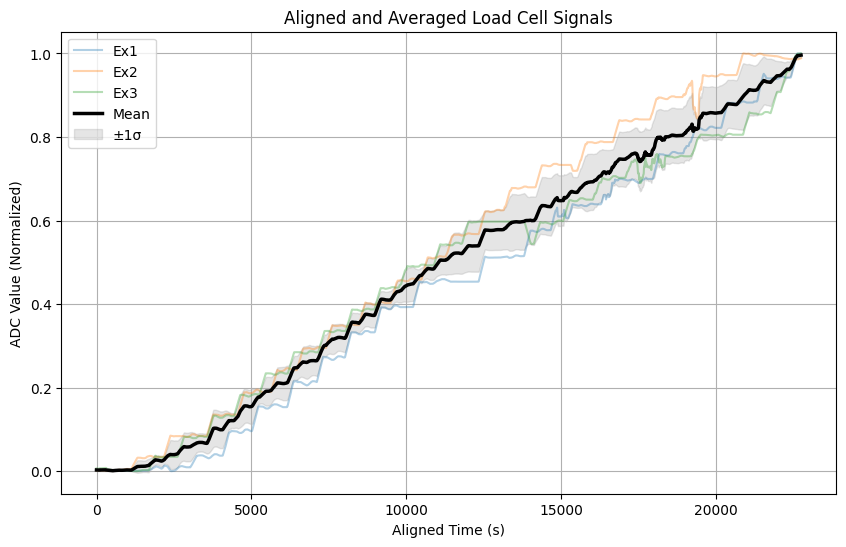

===== Calibration Equation =====
ADC_normalized = 0.000160 * Weight_g + -0.042377
R² = 0.994657


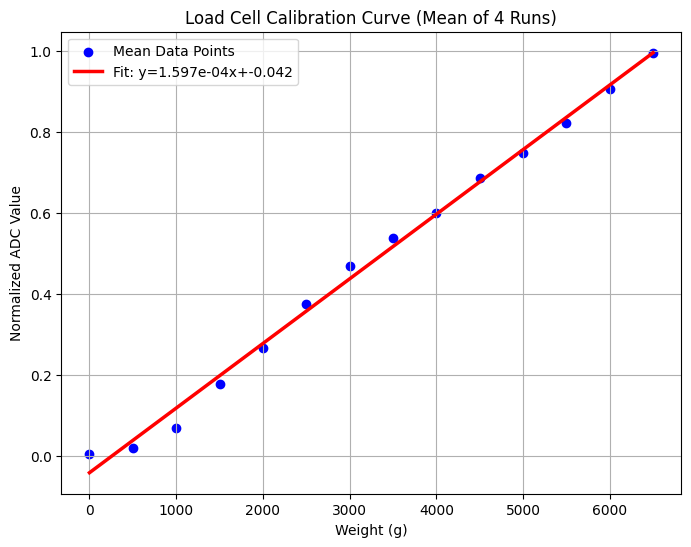

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ====================================================
# SETTINGS
# ====================================================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

WINDOW_SAMPLES = 201
MODE = "xcorr"
REF = 0
N_GRID = 5000
NORMALIZE = True
EXPORT_ALIGNED = True
EXPORT_PATH = "/content/aligned_data.csv"
OUTLIER_METHOD = "exclude_run"   # choose: "none", "clip", "mad", "exclude_run"
EXCLUDE_INDEX = 2                # exclude Ex3 if it’s the noisy one
# ----------------------------------------------------
# Calibration reference weights (grams)
weights_g = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500])
# ====================================================


# ----------------------------------------------------
# Load, smooth, align, normalize, and handle outliers
# ----------------------------------------------------
dfs = []
for path in paths:
    df = pd.read_csv(path).sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    df["Smooth"] = df["Data"].rolling(WINDOW_SAMPLES, center=True, min_periods=WINDOW_SAMPLES // 2).mean()
    dfs.append(df)

t_min = max(df["Time"].min() for df in dfs)
t_max = min(df["Time"].max() for df in dfs)
if not np.isfinite(t_min) or not np.isfinite(t_max) or t_max <= t_min:
    t_min = min(df["Time"].min() for df in dfs)
    t_max = max(df["Time"].max() for df in dfs)
t_common = np.linspace(t_min, t_max, N_GRID)
dt = (t_common[-1] - t_common[0]) / (len(t_common) - 1)

interp_signals = []
for df in dfs:
    t, y = df["Time"].to_numpy(float), df["Smooth"].to_numpy(float)
    mask = np.isfinite(t) & np.isfinite(y)
    if mask.sum() < 2:
        interp_signals.append(np.full_like(t_common, np.nan))
    else:
        interp_signals.append(np.interp(t_common, t[mask], y[mask], left=np.nan, right=np.nan))

def zscore_nan(a):
    mu, sd = np.nanmean(a), np.nanstd(a)
    return (a - mu) / (sd if sd > 0 else 1.0)

signals_z = [zscore_nan(y) for y in interp_signals]
ref = np.nan_to_num(signals_z[REF], nan=0.0)

lags = [0]
for y in signals_z[1:]:
    y_filled = np.nan_to_num(y, nan=0.0)
    corr = np.correlate(y_filled, ref, mode="full")
    lag_idx = np.argmax(corr) - (len(ref) - 1)
    lags.append(lag_idx)

t_aligned = [t_common - lag * dt for lag in lags]

if NORMALIZE:
    interp_signals = [(y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y)) for y in interp_signals]

# Exclude bad run if requested
if OUTLIER_METHOD == "exclude_run":
    bad = EXCLUDE_INDEX
    if 0 <= bad < len(interp_signals):
        interp_signals.pop(bad)
        t_aligned.pop(bad)

# ----------------------------------------------------
# Mean curve computation
# ----------------------------------------------------
stacked = np.vstack(interp_signals)
mean_curve = np.nanmean(stacked, axis=0)
std_curve  = np.nanstd(stacked, axis=0)

plt.figure(figsize=(10,6))
for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
    plt.plot(t_a - t_aligned[0][0], y, alpha=0.35, label=f"Ex{i}")
plt.plot(t_aligned[0] - t_aligned[0][0], mean_curve, 'k', linewidth=2.5, label='Mean')
plt.fill_between(t_aligned[0] - t_aligned[0][0], mean_curve - std_curve, mean_curve + std_curve,
                 alpha=0.2, color='gray', label='±1σ')
plt.title("Aligned and Averaged Load Cell Signals")
plt.xlabel("Aligned Time (s)")
plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
plt.legend()
plt.grid(True)
plt.show()


# ====================================================
# LINEAR CALIBRATION
# ====================================================
# Step 1. Identify plateau values (or use averages at known weights)
# For demonstration, sample equally spaced indices corresponding to weights_g
idx = np.linspace(0, len(mean_curve)-1, len(weights_g)).astype(int)
adc_mean = mean_curve[idx]

# Step 2. Fit linear model
model = LinearRegression()
model.fit(weights_g.reshape(-1, 1), adc_mean)
y_pred = model.predict(weights_g.reshape(-1, 1))
r2 = r2_score(adc_mean, y_pred)

# Step 3. Display equation
print("===== Calibration Equation =====")
print(f"ADC_normalized = {model.coef_[0]:.6f} * Weight_g + {model.intercept_:.6f}")
print(f"R² = {r2:.6f}")

# Step 4. Plot calibration fit
plt.figure(figsize=(8,6))
plt.scatter(weights_g, adc_mean, color='blue', label='Mean Data Points')
plt.plot(weights_g, y_pred, 'r-', linewidth=2.5, label=f'Fit: y={model.coef_[0]:.3e}x+{model.intercept_:.3f}')
plt.title("Load Cell Calibration Curve (Mean of 4 Runs)")
plt.xlabel("Weight (g)")
plt.ylabel("Normalized ADC Value")
plt.grid(True)
plt.legend()
plt.show()


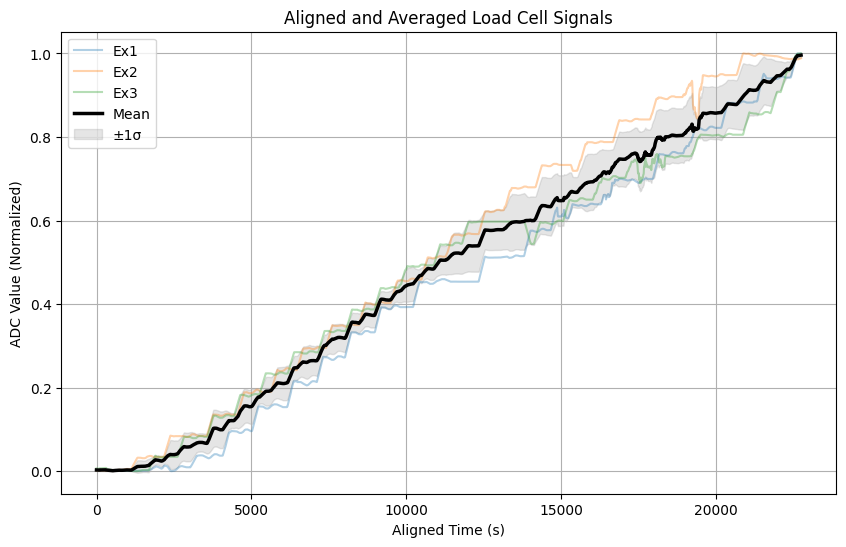

===== Calibration Equation =====
Weight_g = 6226.575905 * ADC_value + 281.228557
R² = 0.994657


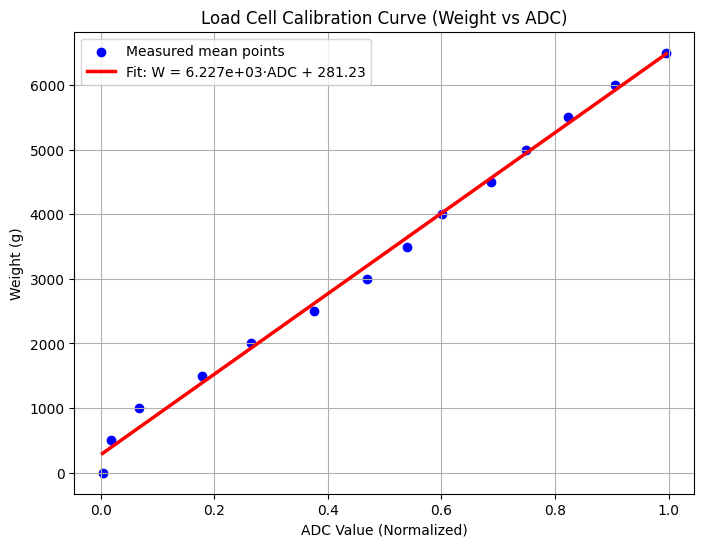

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ====================================================
# SETTINGS
# ====================================================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

WINDOW_SAMPLES = 201
MODE = "xcorr"
REF = 0
N_GRID = 5000
NORMALIZE = True
EXPORT_ALIGNED = True
EXPORT_PATH = "/content/aligned_data.csv"
OUTLIER_METHOD = "exclude_run"   # "none", "clip", "mad", or "exclude_run"
EXCLUDE_INDEX = 2                # Ex3 (noisy) removed
# ----------------------------------------------------
# Calibration reference weights (grams)
weights_g = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500,
                      4000, 4500, 5000, 5500, 6000, 6500])
# ====================================================


# ----------------------------------------------------
# Load, smooth, align, normalize, and handle outliers
# ----------------------------------------------------
dfs = []
for path in paths:
    df = pd.read_csv(path).sort_values("Time").drop_duplicates(subset="Time").reset_index(drop=True)
    df["Smooth"] = df["Data"].rolling(WINDOW_SAMPLES, center=True, min_periods=WINDOW_SAMPLES // 2).mean()
    dfs.append(df)

t_min = max(df["Time"].min() for df in dfs)
t_max = min(df["Time"].max() for df in dfs)
if not np.isfinite(t_min) or not np.isfinite(t_max) or t_max <= t_min:
    t_min = min(df["Time"].min() for df in dfs)
    t_max = max(df["Time"].max() for df in dfs)
t_common = np.linspace(t_min, t_max, N_GRID)
dt = (t_common[-1] - t_common[0]) / (len(t_common) - 1)

interp_signals = []
for df in dfs:
    t, y = df["Time"].to_numpy(float), df["Smooth"].to_numpy(float)
    mask = np.isfinite(t) & np.isfinite(y)
    if mask.sum() < 2:
        interp_signals.append(np.full_like(t_common, np.nan))
    else:
        interp_signals.append(np.interp(t_common, t[mask], y[mask], left=np.nan, right=np.nan))

def zscore_nan(a):
    mu, sd = np.nanmean(a), np.nanstd(a)
    return (a - mu) / (sd if sd > 0 else 1.0)

signals_z = [zscore_nan(y) for y in interp_signals]
ref = np.nan_to_num(signals_z[REF], nan=0.0)

lags = [0]
for y in signals_z[1:]:
    y_filled = np.nan_to_num(y, nan=0.0)
    corr = np.correlate(y_filled, ref, mode="full")
    lag_idx = np.argmax(corr) - (len(ref) - 1)
    lags.append(lag_idx)

t_aligned = [t_common - lag * dt for lag in lags]

if NORMALIZE:
    interp_signals = [(y - np.nanmin(y)) / (np.nanmax(y) - np.nanmin(y)) for y in interp_signals]

# Exclude bad run if requested
if OUTLIER_METHOD == "exclude_run":
    bad = EXCLUDE_INDEX
    if 0 <= bad < len(interp_signals):
        interp_signals.pop(bad)
        t_aligned.pop(bad)

# ----------------------------------------------------
# Mean curve computation
# ----------------------------------------------------
stacked = np.vstack(interp_signals)
mean_curve = np.nanmean(stacked, axis=0)
std_curve  = np.nanstd(stacked, axis=0)

plt.figure(figsize=(10,6))
for i, (t_a, y) in enumerate(zip(t_aligned, interp_signals), start=1):
    plt.plot(t_a - t_aligned[0][0], y, alpha=0.35, label=f"Ex{i}")
plt.plot(t_aligned[0] - t_aligned[0][0], mean_curve, 'k', linewidth=2.5, label='Mean')
plt.fill_between(t_aligned[0] - t_aligned[0][0], mean_curve - std_curve, mean_curve + std_curve,
                 alpha=0.2, color='gray', label='±1σ')
plt.title("Aligned and Averaged Load Cell Signals")
plt.xlabel("Aligned Time (s)")
plt.ylabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
plt.legend(); plt.grid(True)
plt.show()


# ====================================================
# CALIBRATION (Weight as output)
# ====================================================
# Sample equally spaced points from mean curve for each reference weight
idx = np.linspace(0, len(mean_curve)-1, len(weights_g)).astype(int)
adc_mean = mean_curve[idx]

# Linear regression:  Weight = a * ADC + b
model = LinearRegression()
model.fit(adc_mean.reshape(-1, 1), weights_g)
weight_pred = model.predict(adc_mean.reshape(-1, 1))
r2 = r2_score(weights_g, weight_pred)

print("===== Calibration Equation =====")
print(f"Weight_g = {model.coef_[0]:.6f} * ADC_value + {model.intercept_:.6f}")
print(f"R² = {r2:.6f}")

# ----------------------------------------------------
# Plot calibration line
# ----------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(adc_mean, weights_g, color='blue', label='Measured mean points')
plt.plot(adc_mean, weight_pred, 'r-', linewidth=2.5,
         label=f'Fit: W = {model.coef_[0]:.3e}·ADC + {model.intercept_:.2f}')
plt.title("Load Cell Calibration Curve (Weight vs ADC)")
plt.xlabel("ADC Value (Normalized)" if NORMALIZE else "ADC Value")
plt.ylabel("Weight (g)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
weights_g = np.arange(0, 10001, 500)  # 21 plateaus including 10,000g

t = t_aligned[0] - t_aligned[0][0]
y = mean_curve
speed = np.abs(np.gradient(y, t))
hi = np.nanpercentile(speed, 90)   # rising segments
lo = np.nanpercentile(speed, 30)   # plateaus

# Find change points where we leave/enter plateaus
edges = np.where(speed > hi)[0]
# Debounce edges (min gap in samples)
min_gap = max(50, len(y)//(len(weights_g)*4))
edges = np.r_[0, edges[np.diff(np.r_[0, edges]) > min_gap], len(y)-1]

# Build plateau windows between edges and average low-derivative parts
adc_means = []
for i in range(len(edges)-1):
    s, e = edges[i], edges[i+1]
    mask = speed[s:e] < lo
    if np.any(mask):
        adc_means.append(np.nanmean(y[s:e][mask]))
# Ensure we have the same count as weights (trim or pad as needed)
adc_means = np.array(adc_means[:len(weights_g)])

# Fit Weight = a*ADC + b
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression().fit(adc_means.reshape(-1,1), weights_g[:len(adc_means)])
print(f"Weight = {model.coef_[0]:.1f} * ADC + {model.intercept_:.1f}")


Weight = 8519.8 * ADC + 160.0


Detected 187 plateaus
Linear model: W = 1.786154 * Data + -409.307643
R² = 0.6246


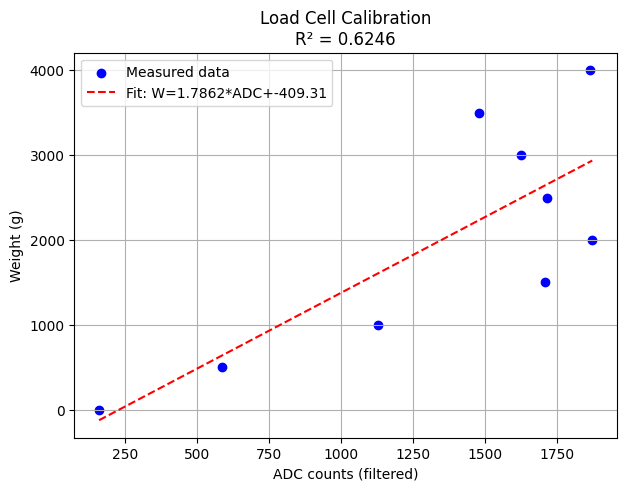

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt
from sklearn.linear_model import LinearRegression

# === 1) โหลดทุกไฟล์ ===
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

dfs = []
for p in paths:
    df = pd.read_csv(p)
    # ปรับชื่อคอลัมน์ให้ตรง (เช่น 'Time','ADC') — แก้ตรงนี้ให้ตรงกับไฟล์คุณ
    if 'Time' not in df.columns:
        df.columns = ['Time', 'Data']
    df = df.sort_values('Time')
    dfs.append(df)

# รวมทุกไฟล์เป็น DataFrame เดียว
df_all = pd.concat(dfs, ignore_index=True)

# === 2) Preprocessing ===
# (1) Median filter กันสไปก์
df_all['ADC_med'] = medfilt(df_all['Data'], kernel_size=7)

# (2) Low-pass filter (Butterworth)
fs = 50  # ตัวอย่าง sampling rate
cutoff = 8
b, a = butter(3, cutoff / (0.5 * fs), btype='low')
df_all['ADC_filt'] = filtfilt(b, a, df_all['ADC_med'])

# === 3) Detect plateau (ช่วงที่นิ่ง) ===
adc = df_all['ADC_filt'].values
diff_adc = np.abs(np.gradient(adc))
is_flat = diff_adc < 0.02 * np.std(adc)  # ปรับ threshold ได้
df_all['flat'] = is_flat

# group plateau regions
min_len = int(0.8 * fs)
segments = []
current = []

for i, flat in enumerate(is_flat):
    if flat:
        current.append(i)
    elif current:
        if len(current) >= min_len:
            segments.append(current)
        current = []

# === 4) หาเฉลี่ย ADC ของแต่ละ plateau ===
adc_means = [np.mean(adc[s]) for s in segments]
print(f"Detected {len(adc_means)} plateaus")

# === 5) ใส่ค่ามวลอ้างอิง (กรัม) ===
W_ref = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])  # ปรับตามจริง
n = min(len(adc_means), len(W_ref))
X = np.array(adc_means[:n]).reshape(-1, 1)
y = W_ref[:n]

# === 6) Linear regression ===
model = LinearRegression().fit(X, y)
a = model.coef_[0]
b = model.intercept_
R2 = model.score(X, y)

print(f"Linear model: W = {a:.6f} * Data + {b:.6f}")
print(f"R² = {R2:.4f}")

# === 7) Plot ===
plt.figure(figsize=(7,5))
plt.scatter(X, y, color='blue', label='Measured data')
x_line = np.linspace(min(X), max(X), 100).reshape(-1,1)
plt.plot(x_line, model.predict(x_line), 'r--', label=f'Fit: W={a:.4f}*ADC+{b:.2f}')
plt.xlabel('ADC counts (filtered)')
plt.ylabel('Weight (g)')
plt.title(f'Load Cell Calibration\nR² = {R2:.4f}')
plt.grid(True)
plt.legend()
plt.show()


Detected plateaus (total) = 101  → used 21 points
Linear model:  W = 2.868759 * ADC + -916.206699
R² = 0.5298
       ADC_mean  Weight_true(g)  Weight_pred(g)  Residual(g)
0    392.441955             0.0      209.614615  -209.614615
1   1465.396602           500.0     3287.662712 -2787.662712
2   1747.118407           997.0     4095.854623 -3098.854623
3   1614.345026          1495.6     3714.959815 -2219.359815
4   1853.685467          1996.4     4401.569814 -2405.169814
5   1712.618816          2590.4     3996.883618 -1406.483618
6   1904.230654          3088.6     4546.571765 -1457.971765
7   2839.526810          3584.8     7229.710853 -3644.910853
8    950.636997          4081.4     1810.941562  2270.458438
9    901.379779          4579.0     1669.634482  2909.365518
10  1046.792492          5088.0     2086.788484  3001.211516
11  2059.778387          5485.2     4992.800696   492.399304


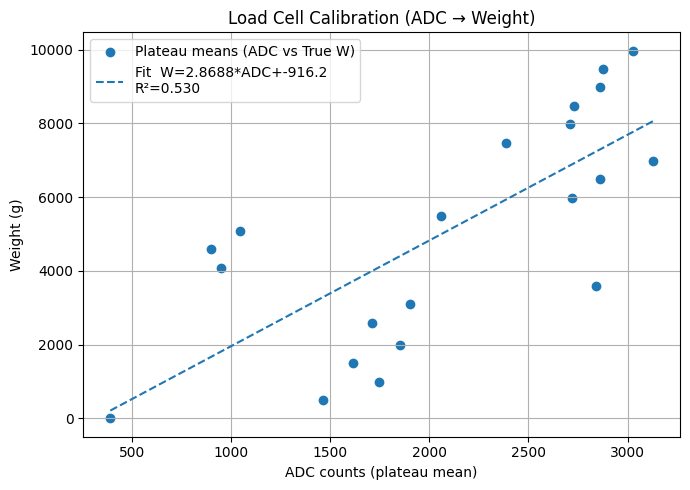

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt
from sklearn.linear_model import HuberRegressor
from pathlib import Path

# -------------------- CONFIG --------------------
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv",
]

# เติม "น้ำหนักจริง" (True_Weight_mean) ตามที่คุณวัดได้จริง
true_weights = [
    0, 500, 997, 1495.6, 1996.4, 2590.4, 3088.6, 3584.8, 4081.4, 4579,
    5088, 5485.2, 5985.4, 6482.8, 6979.6, 7480.2, 7978.2, 8477.2, 8973.6,
    9469.2, 9969.4
]
# ปรับตามจำนวนสเต็ปที่มีจริงในชุด ADC (ส่วนเกินจะถูกตัดทิ้ง)

fs = 50.0     # Hz (ตั้งตามที่บันทึกออกจาก Simulink)
median_win_s = 0.25
lp_cut_hz = 8.0
flat_grad_frac = 0.003   # เข้ม: เกณฑ์นิ่งจาก gradient (ส่วนของช่วงไดนามิก)
min_flat_s = 1.2         # plateau ต้องนิ่งอย่างน้อยเท่านี้
use_tail_frac = 0.3      # เฉลี่ย 30% ท้ายของแต่ละ plateau เพื่อตัด transient

# ----------------- HELPER FUNCTIONS -----------------
def _find_cols(df):
    # พยายามหา time/adc column อัตโนมัติ
    time_candidates = [c for c in df.columns if c.lower() in ("time","t","timestamp")]
    adc_candidates  = [c for c in df.columns if c.lower() in ("adc","data","value","counts")]
    if not time_candidates:
        # ถ้าไม่มี ให้สร้าง time เป็น index ลำดับ
        df = df.copy()
        df["__time__"] = np.arange(len(df))/fs
        tcol = "__time__"
    else:
        tcol = time_candidates[0]
    if not adc_candidates:
        raise ValueError("ไม่พบคอลัมน์ ADC/Data ในไฟล์")
    acol = adc_candidates[0]
    return df, tcol, acol

def preprocess_adc(t, x, fs, median_win_s, lp_cut_hz):
    # median filter กันสไปก์
    k = max(3, int(round(median_win_s*fs))|1)  # odd
    x1 = medfilt(x, kernel_size=k)
    # low-pass Butterworth
    b,a = butter(3, lp_cut_hz/(0.5*fs), btype="low")
    x2 = filtfilt(b,a,x1)
    return x2

def detect_plateaus(x, fs, flat_grad_frac, min_flat_s):
    # ใช้ gradient แบบ robust + moving average
    g = np.abs(np.gradient(x))
    thr = flat_grad_frac*(np.max(x)-np.min(x))
    win = max(5, int(0.6*fs))
    g_ma = pd.Series(g).rolling(win, center=True, min_periods=1).mean().values
    is_flat = g_ma < thr

    # รวมช่วงต่อเนื่องและคัดความยาวขั้นต่ำ
    idx = np.where(is_flat)[0]
    segments = []
    if len(idx)==0:
        return segments
    cuts = np.where(np.diff(idx)>1)[0]
    starts = np.r_[0, cuts+1]
    ends   = np.r_[cuts, len(idx)-1]
    min_len = int(min_flat_s*fs)

    for s,e in zip(starts, ends):
        run = idx[s:e+1]
        if len(run) >= min_len:
            segments.append(run.tolist())
    return segments

# ----------------- MAIN PIPELINE -----------------
adc_means_all = []
per_step_rows = []  # เก็บรายละเอียดทุก plateau

for p in paths:
    df = pd.read_csv(p)
    df, tcol, acol = _find_cols(df)
    df = df.sort_values(by=tcol).reset_index(drop=True)
    t = df[tcol].to_numpy().astype(float)
    # normalize time เริ่มที่ 0 (ถ้าจำเป็น)
    if t.max() > 1e6:  # เผื่อเป็นหน่วย tick
        t = (t - t[0]) / fs
    else:
        t = t - t[0]

    x_raw = df[acol].to_numpy().astype(float)
    x_f = preprocess_adc(t, x_raw, fs, median_win_s, lp_cut_hz)
    segs = detect_plateaus(x_f, fs, flat_grad_frac, min_flat_s)

    # เฉลี่ยช่วงท้ายของแต่ละ plateau
    for si, seg in enumerate(segs):
        L = len(seg)
        tail = seg[int((1.0-use_tail_frac)*L):]
        mean_adc = float(np.mean(x_f[tail]))
        per_step_rows.append({
            "file": Path(p).name, "step": si+1, "ADC_mean": mean_adc
        })
        adc_means_all.append(mean_adc)

# สร้าง DataFrame สรุปทุก plateau (ตามลำดับเวลา)
df_steps = pd.DataFrame(per_step_rows)
df_steps["global_order"] = np.arange(1, len(df_steps)+1)
df_steps = df_steps.sort_values(["global_order"]).reset_index(drop=True)

# จับคู่จำนวนจุดให้เท่ากับจำนวน true_weights
N = min(len(df_steps), len(true_weights))
adc_vec = df_steps["ADC_mean"].values[:N]
w_true = np.array(true_weights[:N], dtype=float)

# ---------- Robust linear fit: W = a*ADC + b ----------
X = adc_vec.reshape(-1,1)
hub = HuberRegressor(epsilon=1.35).fit(X, w_true)
a = float(hub.coef_[0])
b = float(hub.intercept_)
w_pred = hub.predict(X)
R2 = 1 - np.sum((w_true - w_pred)**2)/np.sum((w_true - np.mean(w_true))**2)

print(f"Detected plateaus (total) = {len(df_steps)}  → used {N} points")
print(f"Linear model:  W = {a:.6f} * ADC + {b:.6f}")
print(f"R² = {R2:.4f}")

# ตารางเทียบค่าและ residual
out = pd.DataFrame({
    "ADC_mean": adc_vec,
    "Weight_true(g)": w_true,
    "Weight_pred(g)": w_pred,
    "Residual(g)": w_true - w_pred
})
print(out.head(12))  # ดูตัวอย่างแถวแรก

# ---------- Visualization ----------
plt.figure(figsize=(7,5))
plt.scatter(adc_vec, w_true, label="Plateau means (ADC vs True W)")
xline = np.linspace(adc_vec.min(), adc_vec.max(), 200)
plt.plot(xline, a*xline + b, "--", label=f"Fit  W={a:.4f}*ADC+{b:.1f}\nR²={R2:.3f}")
plt.xlabel("ADC counts (plateau mean)")
plt.ylabel("Weight (g)")
plt.title("Load Cell Calibration (ADC → Weight)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv"
]

adc_means = []
for p in paths:
    df = pd.read_csv(p)
    col_adc = [c for c in df.columns if c.lower() in ("adc","data","value")][0]
    adc = df[col_adc].astype(float)
    # ใช้ค่าเฉลี่ยช่วงท้าย 20 % ของข้อมูล (ลดผลตอนเปลี่ยน step)
    n_tail = int(0.2 * len(adc))
    adc_means.append(adc[-n_tail:].mean())

adc_means = np.array(adc_means)
print("ADC mean per file:", adc_means)


ADC mean per file: [2761.54223138 2935.54926312 2147.8210695  2604.25548183]


In [ ]:
true_weights = np.array([0, 500, 1000, 1500])  # g


W = -0.919223 * ADC + 3151.279384,  R² = 0.2316


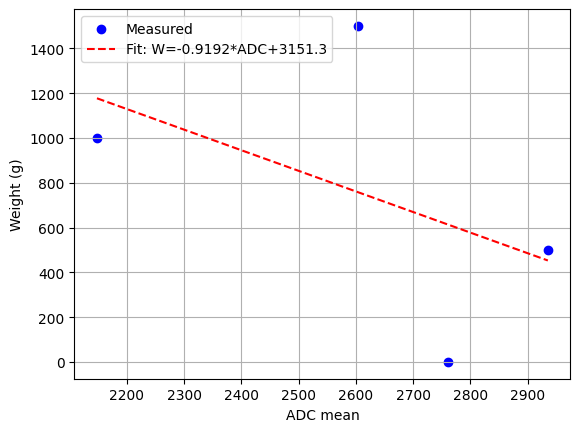

In [ ]:
X = adc_means.reshape(-1,1)
y = true_weights

model = LinearRegression().fit(X, y)
a = model.coef_[0]
b = model.intercept_
R2 = model.score(X, y)

print(f"W = {a:.6f} * ADC + {b:.6f},  R² = {R2:.4f}")

plt.scatter(X, y, color="blue", label="Measured")
xline = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
plt.plot(xline, model.predict(xline), "r--",
         label=f"Fit: W={a:.4f}*ADC+{b:.1f}")
plt.xlabel("ADC mean")
plt.ylabel("Weight (g)")
plt.legend(); plt.grid(); plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import medfilt, butter, filtfilt

def infer_fs(t):
    """เดา fs จากคอลัมน์เวลา (พยายามจัดการสเกล ms→s อัตโนมัติ)"""
    t = np.asarray(t, dtype=float)
    # normalize ให้เริ่มที่ 0
    t = t - np.nanmin(t)
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        return None, t  # เดาไม่ได้

    fs_est = 1.0 / np.median(dt)

    # Heuristic: ถ้า fs_est ต่ำผิดปกติเมื่อเทียบกับ cutoff ที่จะใช้
    # และช่วงเวลาเฉลี่ยดูเหมือนเป็นมิลลิวินาที ให้ลองแปลง ms→s
    if fs_est < 2 and np.median(dt) > 1.0:
        # น่าจะเป็นมิลลิวินาที → แปลงเป็นวินาที
        t = t / 1000.0
        dt = np.diff(t)
        dt = dt[np.isfinite(dt) & (dt > 0)]
        if dt.size:
            fs_est = 1.0 / np.median(dt)

    return float(fs_est), t

def preprocess_adc(adc, fs, median_win_s=0.25, lp_cut_hz=8.0):
    """
    - median filter กันสไปก์
    - low-pass Butterworth (พร้อมคลิป Wn ให้อยู่ใน (0,1))
    """
    adc = np.asarray(adc, dtype=float)

    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"Invalid fs: {fs}")

    # --- median filter ---
    k = int(round(max(3, median_win_s * fs)))
    # บังคับให้เป็นเลขคี่และไม่ยาวเกินความยาวสัญญาณ
    k = min(len(adc) - (1 - len(adc) % 2), k)  # เผื่อกรณีพอดีกับความยาว
    if k < 3:
        k = 3
    if k % 2 == 0:
        k += 1
    x1 = medfilt(adc, kernel_size=k)

    # --- low-pass ---
    # บังคับ cutoff ไม่เกิน 0.45*fs (กันเข้าใกล้ Nyquist)
    cutoff = min(lp_cut_hz, 0.45 * fs)
    # คำนวณ Wn และคลิปให้อยู่ใน (0,1)
    Wn = cutoff / (0.5 * fs)
    Wn = float(np.clip(Wn, 1e-4, 0.99))

    b, a = butter(3, Wn, btype="low")
    x2 = filtfilt(b, a, x1)

    return x2


[INFO] Estimated fs per file:
  - Ex1.csv: 1.000 Hz
  - Ex2.csv: 1.000 Hz
  - Ex5.csv: 1.000 Hz
  - Ex3.csv: 1.000 Hz
[INFO] Using fs = 1.000 Hz for filtering parameters (median/LPF)

[INFO] Detected major plateaus = 2 (expected ~21)

Linear model:  W = 13197.046801 * ADC + -395975.496972
R² = 1.0000

   step   ADC_mean  Weight_true(g)  Weight_pred(g)   Residual(g)
0     0  30.004857             0.0   -5.820766e-11  5.820766e-11
1     1  30.194293          2500.0    2.500000e+03  5.820766e-11


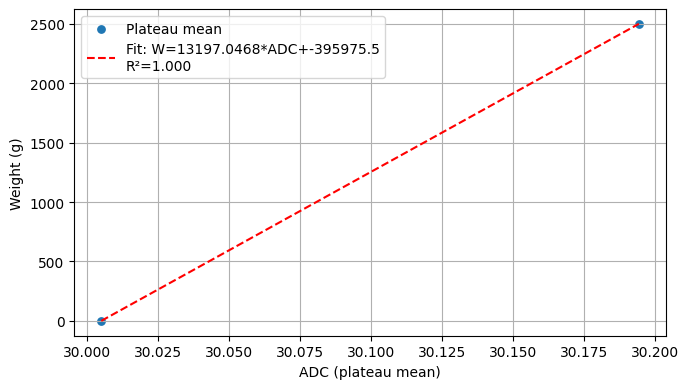

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt
from sklearn.linear_model import LinearRegression
from pathlib import Path

# ================== CONFIG ==================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv",
]
# คำสันนิษฐานชื่อคอลัมน์
TIME_CANDIDATES = ("time", "timestamp", "t")
ADC_CANDIDATES  = ("adc", "data", "value", "counts")

# Preprocess params
fs_hint      = None     # ถ้ารู้ sampling rate ใส่เช่น 50.0; ถ้าไม่รู้จะเดาจาก Time
median_win_s = 0.25     # median filter (s)
lp_cut_hz    = 8.0      # low-pass cutoff (Hz); จะปรับอัตโนมัติถ้าเข้าใกล้ Nyquist
min_flat_s   = 1.0      # plateau ต้องนิ่ง >= min_flat_s วินาที
tail_frac    = 0.35     # เฉลี่ยเฉพาะส่วนท้ายของ plateau (ลด transient)

# สเต็ปจริง 0.5 kg → 10 kg (รวมศูนย์) = 21 จุด
weights_true = np.arange(0, 10000 + 1, 500, dtype=float)  # g

# ================== HELPERS ==================
def find_cols(df: pd.DataFrame):
    cols = {c.lower(): c for c in df.columns}
    tcol = next((cols[c] for c in TIME_CANDIDATES if c in cols), None)
    acol = next((cols[c] for c in ADC_CANDIDATES  if c in cols), None)
    if acol is None:
        # ถ้าไม่มีชื่อที่คาด ให้เดาด้วย heuristic ง่ายๆ: เลือกคอลัมน์ตัวเลขที่ค่าวิ่งมากที่สุด
        num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
        if not num_cols:
            raise ValueError("ไม่พบคอลัมน์ ADC/Data/Value/Counts และไม่มีคอลัมน์ตัวเลขเลย")
        acol = max(num_cols, key=lambda c: df[c].astype(float).std())
    return tcol, acol

def infer_fs_and_time_seconds(t_raw: np.ndarray):
    """
    คืนค่า (fs_est, t_sec) โดย:
    - normalize เวลาให้เริ่มที่ 0
    - ตรวจว่า time scale น่าจะเป็น ms หรือ s
    """
    t = np.asarray(t_raw, dtype=float)
    t = t - np.nanmin(t)
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        return None, t  # เดา fs ไม่ได้

    fs_est = 1.0 / np.median(dt)

    # ถ้าดูเหมือนหน่วย ms (dt ใหญ่กว่าหลายหน่วย) ให้ลองแปลงเป็น s
    if fs_est < 2 and np.median(dt) > 1.0:
        t = t / 1000.0
        dt = np.diff(t)
        dt = dt[np.isfinite(dt) & (dt > 0)]
        if dt.size:
            fs_est = 1.0 / np.median(dt)

    return float(fs_est), t

def safe_median_kernel(n, fs, win_s):
    """คำนวณ kernel size ของ median filter ให้เป็นเลขคี่และไม่เกินความยาวสัญญาณ"""
    k = max(3, int(round(win_s * fs)))
    if k % 2 == 0:
        k += 1
    if k > n:
        k = n if n % 2 == 1 else n - 1
    if k < 3:
        k = 3 if n >= 3 else n
    return max(3, k)

def preprocess_adc(adc: np.ndarray, fs: float, median_win_s=0.25, lp_cut_hz=8.0):
    """
    - median filter กันสไปก์
    - low-pass Butterworth (ปรับ cutoff อัตโนมัติและคลิป Wn ให้อยู่ใน (0,1))
    """
    adc = np.asarray(adc, dtype=float)
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"Invalid fs: {fs}")

    # Median
    k = safe_median_kernel(len(adc), fs, median_win_s)
    x1 = medfilt(adc, kernel_size=k)

    # Low-pass (ข้ามถ้า fs ต่ำมากเมื่อเทียบ cutoff)
    if lp_cut_hz is None or lp_cut_hz <= 0:
        return x1

    effective_cut = min(lp_cut_hz, 0.45 * fs)  # กันเข้าใกล้ Nyquist
    if fs < 2 * effective_cut:  # เงื่อนไข Nyquist ไม่ผ่าน → งด low-pass
        return x1

    Wn = effective_cut / (0.5 * fs)
    Wn = float(np.clip(Wn, 1e-4, 0.99))
    b, a = butter(3, Wn, btype="low")
    x2 = filtfilt(b, a, x1)
    return x2

def detect_plateaus(x: np.ndarray, fs: float, min_flat_s=1.0):
    """
    แบ่งช่วงนิ่งด้วยเกณฑ์ความชันแบบ robust:
    - gradient → moving average
    - threshold = q1 + 0.15*IQR (ทน outlier)
    """
    x = np.asarray(x, dtype=float)
    g = np.abs(np.gradient(x))
    q1, q3 = np.percentile(g, [25, 75])
    iqr = max(1e-9, q3 - q1)
    thr = q1 + 0.15 * iqr

    win = max(5, int(0.6 * fs))
    g_ma = pd.Series(g).rolling(win, center=True, min_periods=1).mean().values
    is_flat = g_ma < thr

    idx = np.where(is_flat)[0]
    if idx.size == 0:
        return []

    cuts = np.where(np.diff(idx) > 1)[0]
    starts = np.r_[0, cuts + 1]
    ends   = np.r_[cuts, len(idx) - 1]
    min_len = int(min_flat_s * fs)

    segments = []
    for s, e in zip(starts, ends):
        run = idx[s:e+1]
        if len(run) >= min_len:
            segments.append(run.tolist())

    # รวม segment ที่คั่นด้วยช่องว่างสั้น ๆ
    merged = []
    for seg in segments:
        if not merged:
            merged.append(seg)
        else:
            last = merged[-1]
            if seg[0] <= last[-1] + int(0.2 * fs):
                merged[-1] = last + seg
            else:
                merged.append(seg)
    return merged

def take_tail_mean(x: np.ndarray, seg, tail_frac=0.35):
    L = len(seg)
    tail = seg[int((1.0 - tail_frac) * L):]
    return float(np.mean(x[tail]))

# ================== LOAD & NORMALIZE ==================
dfs = []
for p in paths:
    df = pd.read_csv(p)
    tcol, acol = find_cols(df)
    if tcol is None:
        # ไม่มี time: ต้องมี fs_hint
        if fs_hint is None:
            raise ValueError(f"{Path(p).name}: ไฟล์ไม่มีคอลัมน์เวลา และไม่ได้ตั้ง fs_hint")
        n = len(df)
        t_sec = np.arange(n) / fs_hint
    else:
        fs_est, t_sec = infer_fs_and_time_seconds(df[tcol].values)
        if fs_est is None or not np.isfinite(fs_est) or fs_est <= 0:
            if fs_hint is None:
                raise ValueError(f"{Path(p).name}: เดา fs ไม่ได้ และไม่ได้ตั้ง fs_hint")
            # ใช้ fs_hint และ normalize เวลาให้เริ่มที่ 0
            arr = df[tcol].astype(float).values
            t_sec = (arr - arr[0]) / 1.0
            fs_est = fs_hint
    adc = df[acol].astype(float).values
    dfs.append(pd.DataFrame({"Time": t_sec, "ADC": adc, "file": Path(p).name}))

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.sort_values(["file", "Time"]).reset_index(drop=True)

# สรุป fs ต่อไฟล์ (เพื่อแสดงผล/ดีบัก)
fs_by_file = {}
for p in set(all_df["file"]):
    tt = all_df.loc[all_df["file"] == p, "Time"].values
    dt = np.diff(tt)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    fs_by_file[p] = None if dt.size == 0 else 1.0 / np.median(dt)

# ใช้ fs กลางเป็นค่ากลางของไฟล์ต่าง ๆ (หรือใช้ fs_hint)
fs_vals = [v for v in fs_by_file.values() if v is not None and np.isfinite(v) and v > 0]
if not fs_vals and fs_hint is None:
    raise ValueError("เดา sampling rate โดยรวมไม่ได้ และไม่ได้ตั้ง fs_hint")
fs = float(np.median(fs_vals)) if fs_vals else float(fs_hint)

print("[INFO] Estimated fs per file:")
for k, v in fs_by_file.items():
    print(f"  - {k}: {v:.3f} Hz" if v else f"  - {k}: (unknown)")
print(f"[INFO] Using fs = {fs:.3f} Hz for filtering parameters (median/LPF)\n")

# ================== PROCESS & DETECT ==================
plateau_meta = []  # (file, plateau_idx, ADC_mean)
for p in sorted(set(all_df["file"]), key=lambda x: paths.index("/content/"+x) if "/content/"+x in paths else 1e9):
    sub = all_df[all_df["file"] == p].copy()
    x = sub["ADC"].values
    x_f = preprocess_adc(x, fs, median_win_s, lp_cut_hz)
    segs = detect_plateaus(x_f, fs, min_flat_s)

    # เก็บทุก plateau ตามเวลา (ใช้ค่าเฉลี่ยท้ายเพื่อกัน transient)
    for i, seg in enumerate(segs):
        mean_adc = take_tail_mean(x_f, seg, tail_frac=tail_frac)
        plateau_meta.append((p, i, mean_adc))

plateau_df = pd.DataFrame(plateau_meta, columns=["file", "plateau_idx", "ADC_mean"])
if plateau_df.empty:
    raise RuntimeError("ไม่สามารถตรวจพบ plateau จากข้อมูลได้—โปรดปรับ min_flat_s / lp_cut_hz / median_win_s")

# จัดลำดับตามไฟล์แล้วตาม index ของ plateau
file_order = {Path(p).name: i for i, p in enumerate(paths)}
plateau_df["file_order"] = plateau_df["file"].map(file_order).fillna(1e9).astype(int)
plateau_df = plateau_df.sort_values(["file_order", "plateau_idx"]).reset_index(drop=True)

# เลือก 21 จุดแรกตามลำดับ (0→10 kg)
N = min(len(plateau_df), len(weights_true))
adc_vec = plateau_df["ADC_mean"].values[:N]
w_true  = weights_true[:N]

# บังคับ monotonicity อย่างอ่อน (สัญญาณควรเพิ่มตามน้ำหนัก)
if len(adc_vec) >= 2:
    keep = [0]
    span = adc_vec.max() - adc_vec.min()
    tol  = 0.02 * span  # 2% ของช่วง ADC ทั้งหมด
    for i in range(1, len(adc_vec)):
        if adc_vec[i] + tol >= adc_vec[keep[-1]]:
            keep.append(i)
    if len(keep) != len(adc_vec):
        adc_vec = adc_vec[keep]
        w_true  = w_true[keep]

# ถ้ามากกว่า 21 จุด ให้ตัดเหลือ 21
if len(adc_vec) > 21:
    adc_vec = adc_vec[:21]
    w_true  = w_true[:21]

print(f"[INFO] Detected major plateaus = {len(adc_vec)} (expected ~21)\n")

# ================== FIT:  W = a*ADC + b ==================
X = adc_vec.reshape(-1, 1)
y = w_true
lin = LinearRegression().fit(X, y)
a = float(lin.coef_[0])
b = float(lin.intercept_)
R2 = lin.score(X, y)

print(f"Linear model:  W = {a:.6f} * ADC + {b:.6f}")
print(f"R² = {R2:.4f}\n")

# ================== REPORT TABLE ==================
w_pred = lin.predict(X)
out = pd.DataFrame({
    "step": np.arange(len(adc_vec)),
    "ADC_mean": adc_vec,
    "Weight_true(g)": y,
    "Weight_pred(g)": w_pred,
    "Residual(g)": y - w_pred
})
print(out.head(12))

# ================== PLOTS ==================
plt.figure(figsize=(7, 4))
plt.scatter(adc_vec, y, s=28, label="Plateau mean")
xline = np.linspace(adc_vec.min(), adc_vec.max(), 200)
plt.plot(xline, a*xline + b, "r--", label=f"Fit: W={a:.4f}*ADC+{b:.1f}\nR²={R2:.3f}")
plt.xlabel("ADC (plateau mean)")
plt.ylabel("Weight (g)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


[INFO] Ex1.csv: segments=21  valid_means=21/21
[INFO] Ex2.csv: segments=21  valid_means=21/21
[INFO] Ex3.csv: segments=21  valid_means=21/21
[INFO] Ex5.csv: segments=21  valid_means=21/21

[INFO] Aggregated steps (after median across files): 21 (expected ~21)
Linear model:  W = 3.129121 * ADC + -90.273728
R² = 0.9895

     step     ADC_mean  Weight_true(g)  Weight_pred(g)  Residual(g)
0      0    44.502021             0.0       48.978477   -48.978477
1      1    90.440163           500.0      192.724479   307.275521
2      2   225.634576          1000.0      615.764147   384.235853
3      3   412.551985          1500.0     1200.651327   299.348673
4      4   595.307626          2000.0     1772.515827   227.484173
5      5   811.196929          2500.0     2448.059565    51.940435
6      6  1052.958965          3000.0     3204.562215  -204.562215
7      7  1227.513094          3500.0     3750.763194  -250.763194
8      8  1398.048425          4000.0     4284.388867  -284.388867
9      9 

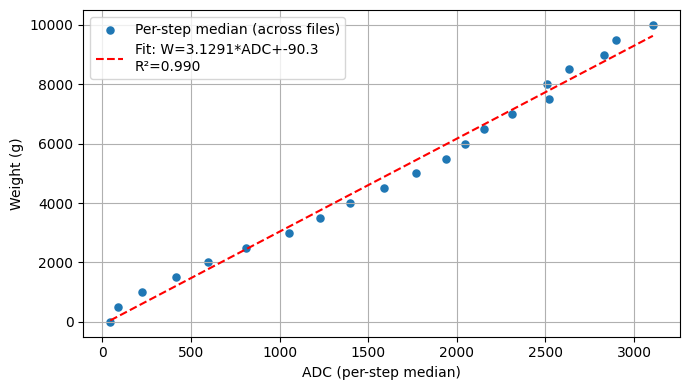

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from sklearn.linear_model import LinearRegression
from pathlib import Path

# ================== CONFIG ==================
paths = [
    "/content/Ex1.csv",
    "/content/Ex2.csv",
    "/content/Ex3.csv",
    "/content/Ex5.csv",
]

TIME_CANDIDATES = ("time", "timestamp", "t")
ADC_CANDIDATES  = ("adc", "data", "value", "counts")

median_win_points = 3     # ใช้จำนวนจุด (fs ต่ำมาก → ใช้ค่าต่ำๆ พอ)
tail_frac         = 0.35  # เฉลี่ยค่าท้ายของเซกเมนต์เพื่อตัด transient
N_STEPS           = 21    # 0.0 → 10.0 kg ทีละ 0.5 kg
weights_true      = np.arange(0, 10000 + 1, 500, dtype=float)

# ================== HELPERS ==================
def find_cols(df: pd.DataFrame):
    cols = {c.lower(): c for c in df.columns}
    tcol = next((cols[c] for c in TIME_CANDIDATES if c in cols), None)
    acol = next((cols[c] for c in ADC_CANDIDATES  if c in cols), None)
    if acol is None:
        # heuristic: เลือกคอลัมน์ตัวเลขที่มีส่วนเบี่ยงเบนมาตรฐานสูงสุดเป็น ADC
        num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
        if not num_cols:
            raise ValueError("ไม่พบคอลัมน์ ADC/Data/Value/Counts และไม่มีคอลัมน์ตัวเลข")
        acol = max(num_cols, key=lambda c: df[c].astype(float).std())
    return tcol, acol

def smooth_median(x: np.ndarray, k: int):
    k = max(3, int(k))
    if k % 2 == 0:
        k += 1
    k = min(k, len(x) if len(x)%2==1 else len(x)-1)
    if k < 3:  # สัญญาณสั้นมาก
        return x.astype(float)
    return medfilt(x.astype(float), kernel_size=k)

def segment_by_changepoints(y: np.ndarray, n_steps: int):
    """
    แยกสัญญาณเป็น n_steps ส่วน โดยเลือก change points = 20 จุด
    จาก |diff| ที่มากที่สุด พร้อม constraint 'ระยะห่างขั้นต่ำ'
    ถ้าหาไม่ได้พอ → fallback แบ่งเท่าๆ กัน
    """
    n = len(y)
    if n < n_steps:
        # สั้นมาก: เติม NaN
        return [ (0, n) ] + [ (n, n) ]*(n_steps-1)

    d = np.abs(np.diff(y))
    # ป้องกัน spur ระยะติดกัน: บังคับระยะห่างขั้นต่ำตามความยาว/จำนวนสเต็ป
    min_gap = max(1, int(np.floor(n / (n_steps * 1.3))))  # ผ่อนคลายเล็กน้อย
    candidate_idx = np.argsort(-d)  # จากมากไปน้อย

    picks = []
    used = np.zeros_like(d, dtype=bool)
    for idx in candidate_idx:
        if used[idx]:
            continue
        # ตรวจ neighborhood
        lo = max(0, idx - min_gap)
        hi = min(len(d)-1, idx + min_gap)
        if not used[lo:hi+1].any():
            picks.append(idx)
            used[lo:hi+1] = True
        if len(picks) >= (n_steps - 1):
            break

    if len(picks) < (n_steps - 1):
        # Fallback: แบ่งเท่าๆ กัน
        cuts = np.linspace(0, n, n_steps+1).astype(int)
        segs = [(cuts[i], cuts[i+1]) for i in range(n_steps)]
        return segs

    cuts = sorted([0] + [p+1 for p in picks] + [n])  # +1 ให้ขอบขวาถัดจาก diff index
    # ทำความสะอาด (กันช่วงว่าง)
    segs = []
    for i in range(len(cuts)-1):
        a, b = cuts[i], cuts[i+1]
        if b <= a:
            continue
        segs.append((a, b))

    # ถ้าจำนวนเซกเมนต์เกิน/ขาด ปรับให้เท่ากับ n_steps
    if len(segs) > n_steps:
        segs = segs[:n_steps]
    elif len(segs) < n_steps:
        # เติมช่วงสุดท้ายซ้อนกับปลาย (เพื่อคงความยาว)
        while len(segs) < n_steps:
            segs.append((n, n))
    return segs

def tail_mean(x: np.ndarray, a: int, b: int, tail_frac: float):
    L = max(0, b - a)
    if L <= 0:
        return np.nan
    start = a + int((1.0 - tail_frac) * L)
    start = min(start, b-1)
    return float(np.nanmean(x[start:b]))

# ================== LOAD & PROCESS PER FILE ==================
per_file_step_means = []  # list of length = len(paths); each is np.array shape (21,)
per_file_names = []

for p in paths:
    df = pd.read_csv(p)
    tcol, acol = find_cols(df)
    x = df[acol].astype(float).values

    # ทำให้เรียบเล็กน้อย (fs ~ 1 Hz → ใช้ median k=3 พอ)
    y = smooth_median(x, median_win_points)

    # บังคับแบ่งเป็น 21 สเต็ป
    segs = segment_by_changepoints(y, N_STEPS)

    # เฉลี่ยช่วงท้ายของแต่ละสเต็ป
    adc_means = [tail_mean(y, a, b, tail_frac) for (a, b) in segs]
    adc_means = np.array(adc_means, dtype=float)

    per_file_step_means.append(adc_means)
    per_file_names.append(Path(p).name)

    print(f"[INFO] {Path(p).name}: segments={len(segs)}  "
          f"valid_means={np.isfinite(adc_means).sum()}/{len(adc_means)}")

# รวมค่าข้ามไฟล์ด้วยมัธยฐาน (ทน outlier)
M = np.vstack(per_file_step_means)   # shape: (n_files, 21)
adc_vec = np.nanmedian(M, axis=0)    # shape: (21,)

# กรอง NaN เผื่อบางไฟล์ช่วงท้ายสั้น
mask = np.isfinite(adc_vec)
adc_vec = adc_vec[mask]
w_true  = weights_true[mask]

print(f"\n[INFO] Aggregated steps (after median across files): {len(adc_vec)} (expected ~21)")

# ================== FIT LINEAR:  W = a*ADC + b ==================
X = adc_vec.reshape(-1, 1)
y = w_true
lin = LinearRegression().fit(X, y)
a = float(lin.coef_[0])
b = float(lin.intercept_)
R2 = lin.score(X, y)

print(f"Linear model:  W = {a:.6f} * ADC + {b:.6f}")
print(f"R² = {R2:.4f}")

# ================== REPORT TABLE ==================
w_pred = lin.predict(X)
report = pd.DataFrame({
    "step": np.arange(len(adc_vec)),
    "ADC_mean": adc_vec,
    "Weight_true(g)": y,
    "Weight_pred(g)": w_pred,
    "Residual(g)": y - w_pred
})
print("\n", report.head(12), "\n")

# ================== PLOTS ==================
plt.figure(figsize=(7, 4))
plt.scatter(adc_vec, y, s=26, label="Per-step median (across files)")
xline = np.linspace(adc_vec.min(), adc_vec.max(), 200)
plt.plot(xline, a*xline + b, "r--", label=f"Fit: W={a:.4f}*ADC+{b:.1f}\nR²={R2:.3f}")
plt.xlabel("ADC (per-step median)")
plt.ylabel("Weight (g)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


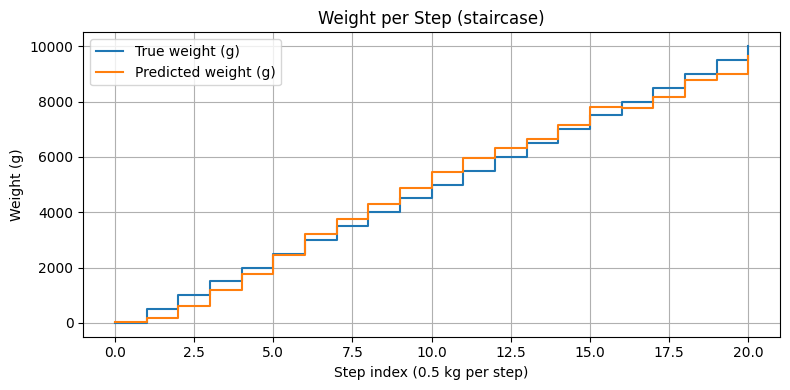

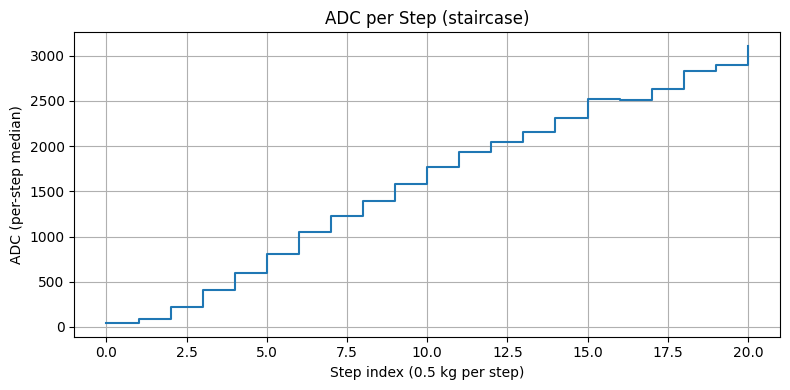

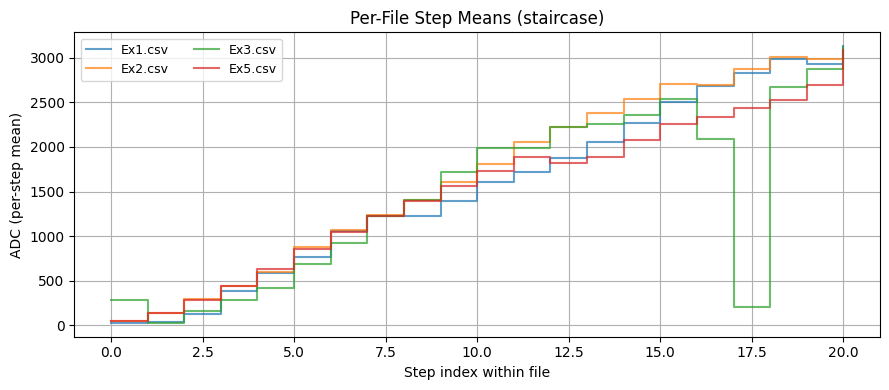

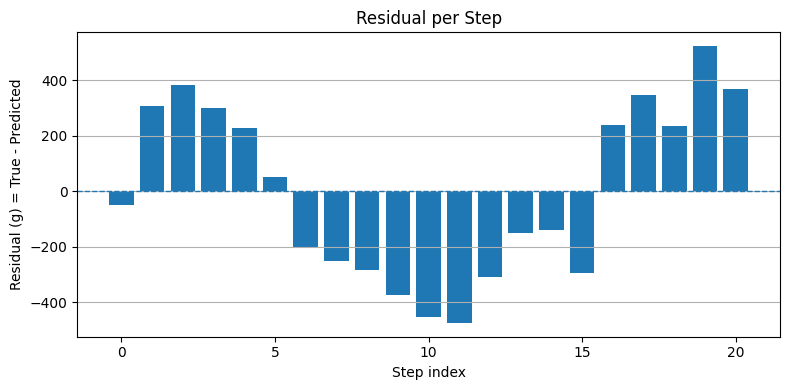

In [ ]:
# ================== STEP PLOTS (STAIRCASE) ==================

# 1) น้ำหนักจริง vs น้ำหนักที่โมเดลทำนาย ตามลำดับสเต็ป (0 → 20)
steps = np.arange(len(adc_vec))
plt.figure(figsize=(8,4))
plt.step(steps, y,      where="post", label="True weight (g)")
plt.step(steps, w_pred, where="post", label="Predicted weight (g)")
plt.xlabel("Step index (0.5 kg per step)")
plt.ylabel("Weight (g)")
plt.title("Weight per Step (staircase)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# 2) ค่า ADC (per-step median across files) แบบขั้นบันได
plt.figure(figsize=(8,4))
plt.step(steps, adc_vec, where="post")
plt.xlabel("Step index (0.5 kg per step)")
plt.ylabel("ADC (per-step median)")
plt.title("ADC per Step (staircase)")
plt.grid(True); plt.tight_layout()
plt.show()

# 3) (ตัวเลือก) เปรียบเทียบค่าเฉลี่ยสเต็ปของแต่ละไฟล์ (Ex1–Ex5) แบบขั้นบันได
plt.figure(figsize=(9,4))
for i, (means, name) in enumerate(zip(per_file_step_means, per_file_names), start=1):
    valid_mask = np.isfinite(means)
    s = np.arange(np.sum(valid_mask))
    plt.step(s, means[valid_mask], where="post", alpha=0.7, label=name)
plt.xlabel("Step index within file")
plt.ylabel("ADC (per-step mean)")
plt.title("Per-File Step Means (staircase)")
plt.grid(True); plt.legend(ncol=2, fontsize=9); plt.tight_layout()
plt.show()

# 4) (เสริม) Residual ต่อสเต็ป เป็นแผนภูมิแท่งอ่านง่าย
plt.figure(figsize=(8,4))
plt.bar(steps, (y - w_pred))
plt.axhline(0, linewidth=1, linestyle="--")
plt.xlabel("Step index")
plt.ylabel("Residual (g) = True - Predicted")
plt.title("Residual per Step")
plt.grid(True, axis="y"); plt.tight_layout()
plt.show()


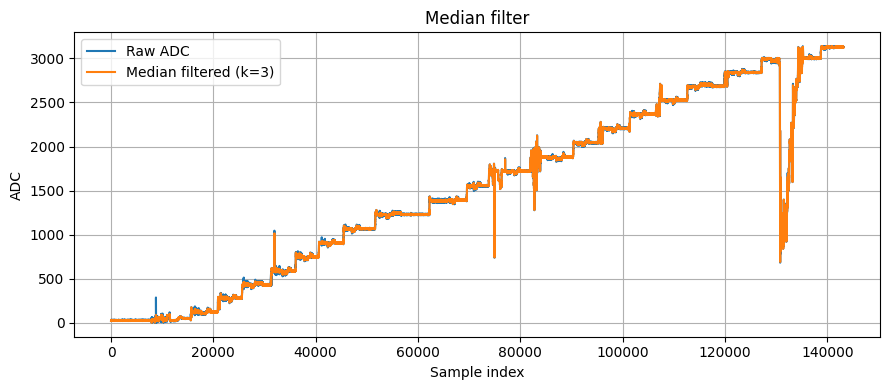

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from pathlib import Path

# ---------- เลือกไฟล์ตัวอย่าง ----------
p = paths[0]
df = pd.read_csv(p)

# หา column ADC แบบเดียวกับในสคริปต์หลัก
def find_adc_col(df):
    cands = [c for c in df.columns if c.lower() in ("adc","data","value","counts")]
    if cands:
        return cands[0]
    num_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.number)]
    return max(num_cols, key=lambda c: df[c].astype(float).std())
acol = find_adc_col(df)

x = df[acol].astype(float).values
y_med = medfilt(x, kernel_size=3)  # k=3 สำหรับ fs ต่ำ ~1 Hz

plt.figure(figsize=(9,4))
plt.plot(x, label="Raw ADC")
plt.plot(y_med, label="Median filtered (k=3)")
plt.title("Median filter")
plt.xlabel("Sample index")
plt.ylabel("ADC")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


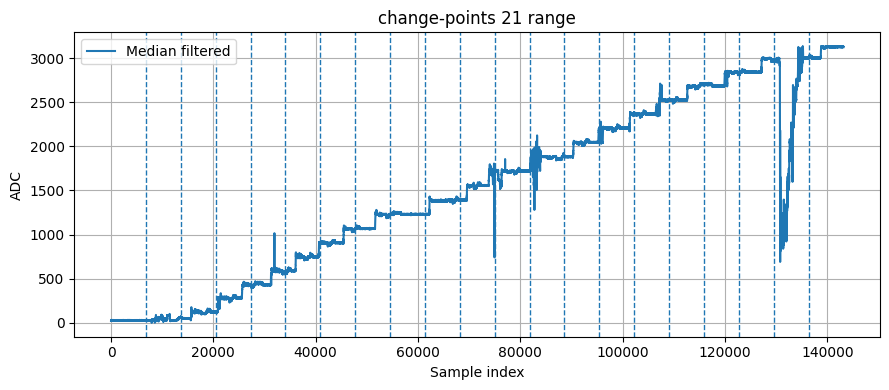

In [ ]:
# ฟังก์ชันแบ่ง 21 ช่วงตามการเปลี่ยนแปลง |diff|
def segment_by_changepoints(y, n_steps=21):
    n = len(y)
    if n < n_steps:
        cuts = np.linspace(0, n, n_steps+1).astype(int)
        return [(cuts[i], cuts[i+1]) for i in range(n_steps)]
    d = np.abs(np.diff(y))
    min_gap = max(1, int(np.floor(n / (n_steps * 1.3))))
    idxs = np.argsort(-d)

    picks, used = [], np.zeros_like(d, bool)
    for idx in idxs:
        lo, hi = max(0, idx-min_gap), min(len(d)-1, idx+min_gap)
        if not used[lo:hi+1].any():
            picks.append(idx)
            used[lo:hi+1] = True
        if len(picks) >= (n_steps-1): break

    if len(picks) < (n_steps-1):
        cuts = np.linspace(0, n, n_steps+1).astype(int)
    else:
        cuts = np.sort(np.r_[0, np.array(picks)+1, n])

    segs = [(int(cuts[i]), int(cuts[i+1])) for i in range(n_steps)]
    return segs

segs = segment_by_changepoints(y_med, n_steps=21)

plt.figure(figsize=(9,4))
plt.plot(y_med, label="Median filtered")
for a,b in segs[:-1]:  # วาดเส้นแบ่ง 20 จุด (พอให้เห็นขั้น)
    plt.axvline(b, linestyle="--", linewidth=1)
plt.title("change-points 21 range")
plt.xlabel("Sample index"); plt.ylabel("ADC")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()


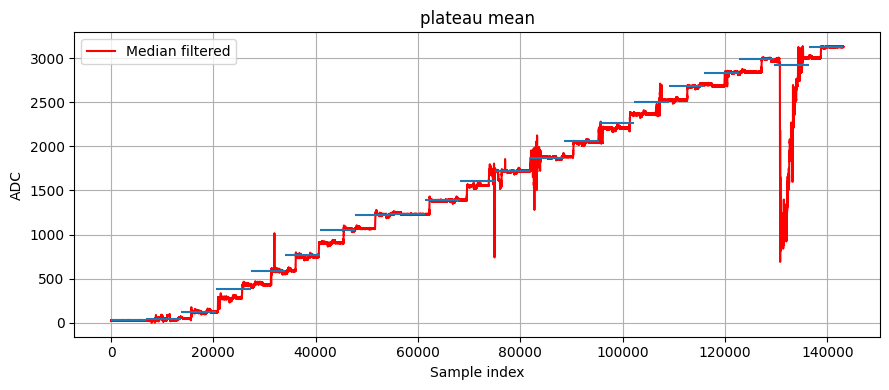

In [ ]:
tail_frac = 0.35  # เฉลี่ย 35% ท้ายของแต่ละช่วง

def tail_mean(x, a, b, tail_frac):
    L = max(0, b-a)
    s = a + int((1.0 - tail_frac)*L)
    s = min(s, b-1)
    return float(np.mean(x[s:b]))

means = [tail_mean(y_med, a, b, tail_frac) for (a,b) in segs]

plt.figure(figsize=(9,4))
plt.plot(y_med,'red', label="Median filtered")
for (a,b), m in zip(segs, means):
    plt.hlines(m, a, b-1)  # เส้นระดับ = ค่าเฉลี่ยปลายช่วง
plt.title("plateau mean")
plt.xlabel("Sample index"); plt.ylabel("ADC")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

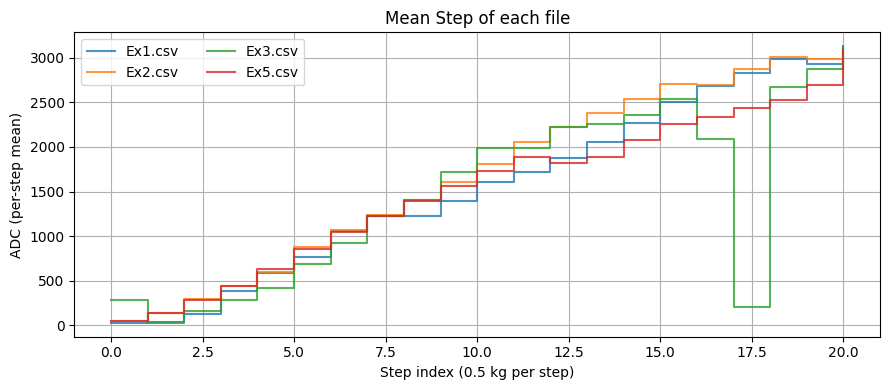

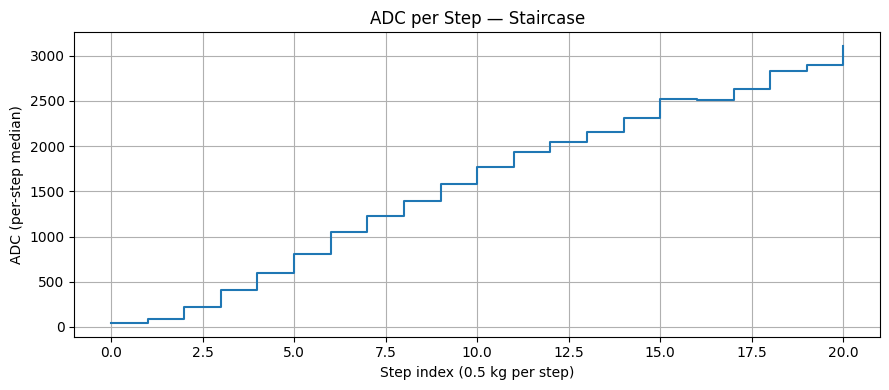

In [ ]:
# per_file_step_means: np.array ต่อไฟล์ (ยาว 21)
# adc_vec: มัธยฐานข้ามไฟล์ (ยาว ~21) — มีจากสคริปต์หลักแล้ว
steps = np.arange(len(adc_vec))

# (ก) เปรียบเทียบค่าต่อสเต็ปของแต่ละไฟล์
plt.figure(figsize=(9,4))
for means, name in zip(per_file_step_means, per_file_names):
    plt.step(np.arange(len(means)), means, where="post", label=name, alpha=0.8)
plt.title("Mean Step of each file")
plt.xlabel("Step index (0.5 kg per step)"); plt.ylabel("ADC (per-step mean)")
plt.grid(True); plt.legend(ncol=2); plt.tight_layout()
plt.show()

# (ข) ค่ามัธยฐานข้ามไฟล์ (ตัวแทนที่เชื่อถือได้) แบบขั้นบันได
plt.figure(figsize=(9,4))
plt.step(steps, adc_vec, where="post")
plt.title("ADC per Step — Staircase")
plt.xlabel("Step index (0.5 kg per step)"); plt.ylabel("ADC (per-step median)")
plt.grid(True); plt.tight_layout()
plt.show()


    Ref_Weight  Weight_real   Weight_sim      Delta    Error_%
0            0     232.2868   291.566834  59.280034  25.520191
1          500     470.9296   526.259792  55.330192  11.749143
2         1000     963.1796  1010.383070  47.203470   4.900796
3         1500    1479.8452  1518.488112  38.642912   2.611281
4         2000    1996.5108  2026.611880  30.101080   1.507684
5         2500    2550.1936  2571.145234  20.951634   0.821570
6         3000    2990.4620  3004.121564  13.659564   0.456771
7         3500    3548.8704  3553.298966   4.428566   0.124788
8         4000    3997.8024  3994.808110  -2.994290   0.074898
9         4500    4497.1408  4485.884976 -11.255824   0.250288
10        5000    5005.9304  4986.262422 -19.667978   0.392894
11        5500    5509.9944  5482.002062 -27.992338   0.508028
12        6000    6021.9344  5985.469298 -36.465102   0.605538
13        6500    6525.2108  6480.428688 -44.782112   0.686294
14        7000    7023.7616  6970.725304 -53.036296   0

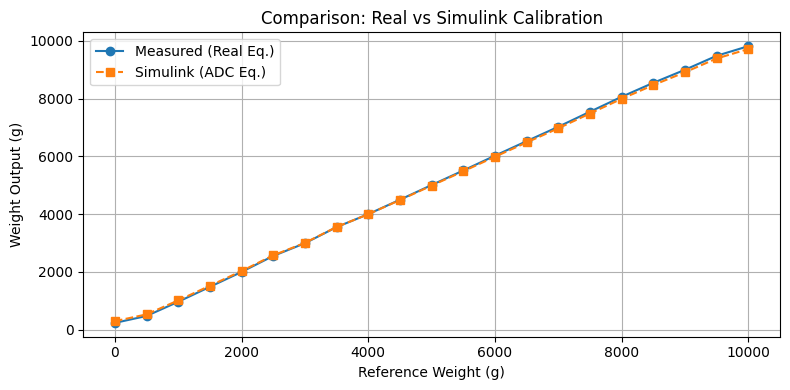

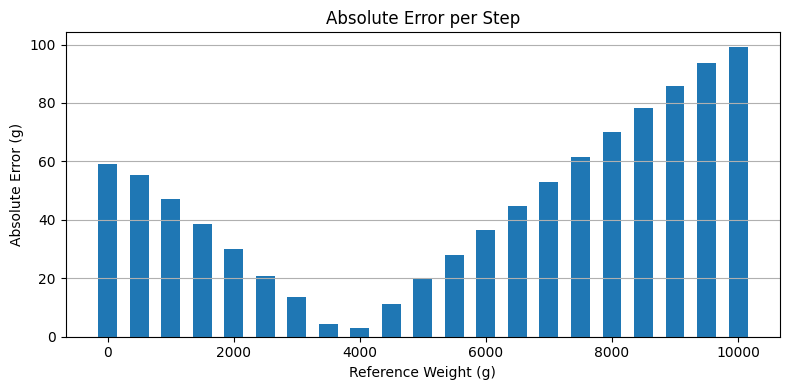

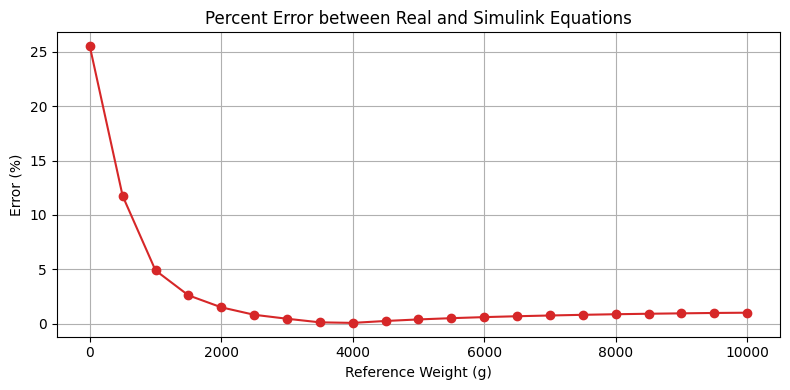

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ข้อมูลดิบ (แทนตารางของคุณ)
# -------------------------------
data = {
    "Ref_Weight": [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000],
    "Vout_mean": [0.0986,0.1592,0.2842,0.4154,0.5466,0.6872,0.799,0.9408,1.0548,1.1816,1.3108,1.4388,1.5688,1.6966,1.8232,1.9556,2.087,2.2098,2.3246,2.4476,2.5322],
    "ADC_mean": [122.354,197.552,352.67,515.472,678.28,852.754,991.484,1167.446,1308.91,1466.256,1626.582,1785.422,1946.738,2105.328,2262.424,2426.722,2589.778,2742.162,2884.616,3037.248,3142.228],
}

df = pd.DataFrame(data)

# -------------------------------
# สมการคำนวณ
# -------------------------------
df["Weight_real"] = 3938 * df["Vout_mean"] - 156
df["Weight_sim"]  = 3.121 * df["ADC_mean"] - 90.3
df["Delta"]       = df["Weight_sim"] - df["Weight_real"]
df["Error_abs"]   = df["Delta"].abs()
df["Error_%"]     = (df["Error_abs"] / df["Weight_real"]) * 100

# -------------------------------
# สรุปผลลัพธ์ตาราง
# -------------------------------
print(df[["Ref_Weight", "Weight_real", "Weight_sim", "Delta", "Error_%"]])

print("\nค่าเฉลี่ยความคลาดเคลื่อน (Mean %Error):", df["Error_%"].mean())
print("ค่าสูงสุด (Max %Error):", df["Error_%"].max())

# -------------------------------
# กราฟเปรียบเทียบ
# -------------------------------

# 1) ค่าจริง vs จำลอง
plt.figure(figsize=(8,4))
plt.plot(df["Ref_Weight"], df["Weight_real"], "o-", label="Measured (Real Eq.)")
plt.plot(df["Ref_Weight"], df["Weight_sim"], "s--", label="Simulink (ADC Eq.)")
plt.xlabel("Reference Weight (g)")
plt.ylabel("Weight Output (g)")
plt.title("Comparison: Real vs Simulink Calibration")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

# 2) กราฟ Error Absolute (g)
plt.figure(figsize=(8,4))
plt.bar(df["Ref_Weight"], df["Error_abs"], width=300)
plt.xlabel("Reference Weight (g)")
plt.ylabel("Absolute Error (g)")
plt.title("Absolute Error per Step")
plt.grid(True, axis="y"); plt.tight_layout()
plt.show()

# 3) กราฟ Percent Error (%)
plt.figure(figsize=(8,4))
plt.plot(df["Ref_Weight"], df["Error_%"], "o-", color="tab:red")
plt.xlabel("Reference Weight (g)")
plt.ylabel("Error (%)")
plt.title("Percent Error between Real and Simulink Equations")
plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# adc_vec: ค่า ADC ต่อสเต็ป (21 จุด), w_true: น้ำหนักจริง (g)
ADC0 = adc_vec[0]              # หรือใช้ค่าเฉลี่ยหลายวินาทีท้ายของ plateau=0g
X = (adc_vec - ADC0).reshape(-1,1)
y = w_true

lin0 = LinearRegression(fit_intercept=False).fit(X, y)  # ฟิตผ่านจุดกำเนิด
a = float(lin0.coef_[0])                                # ไม่มี intercept แล้ว
print(f"W = {a:.6f} * (ADC - {ADC0:.3f})")


W = 3.151715 * (ADC - 44.502)


In [ ]:
import numpy as np
from scipy.optimize import linprog

# x = ADC_mean (เวกเตอร์), y = True_Weight_mean (g)
# ใช้ ADC0 จากค่า plateau 0 g ของคุณ (เช่น 44.502)
ADC0 = 44.502
x = np.asarray(adc_vec)  # ยาว ~21 จุด
y = np.asarray(w_true)

# ตัวแปร [a, b, t]
# เป้าหมาย: minimize t  -> c = [0, 0, 1]
c = np.array([0.0, 0.0, 1.0])

# อสมการ:  a*x + b - y <= t   ->  a*x + b - t <= y
#          -a*x - b + y <= t   -> -a*x - b - t <= -y
A_ub = []
b_ub = []
for xi, yi in zip(x, y):
    A_ub.append([ xi, 1.0, -1.0]) ; b_ub.append( yi)
    A_ub.append([-xi,-1.0, -1.0]) ; b_ub.append(-yi)
A_ub = np.array(A_ub, float)
b_ub = np.array(b_ub, float)

# สมการเท่ากับ: a*ADC0 + b = 0  ->  [ADC0, 1, 0] · [a,b,t] = 0
A_eq = np.array([[ADC0, 1.0, 0.0]])
b_eq = np.array([0.0])

# bound: a >= 0, b free, t >= 0
bounds = [(0, None), (None, None), (0, None)]

res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds=bounds, method="highs")
a_opt, b_opt, t_opt = res.x
print(f"Minimax fit: W = {a_opt:.6f} * ADC + {b_opt:.6f},  max|error| ≈ {t_opt:.3f} g")

Minimax fit: W = 3.160070 * ADC + -140.629442,  max|error| ≈ 483.767 g


[Affine] W_corr = 1.02381971 * W_sim + -112.06691639
MAE = 46.819 g,  Max|Error| = 186.752 g,  MAPE ≈ 891.052%


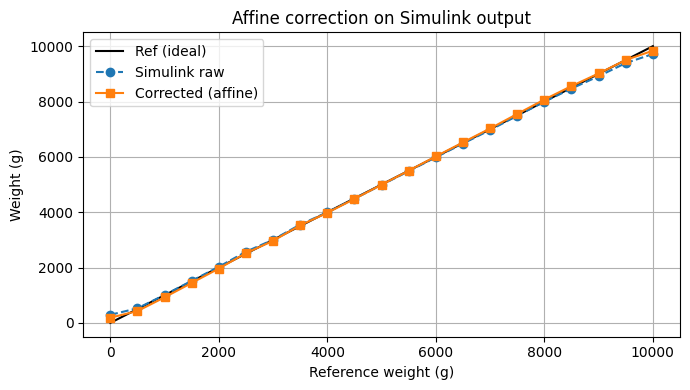

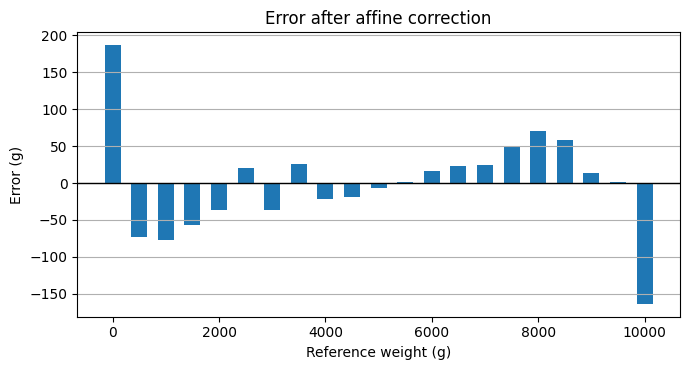

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ----- ข้อมูลของคุณ -----
ref = np.array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
                 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000], float)

wsim = np.array([  291.866834,  526.559792, 1010.683070, 1518.788112, 2026.911880,
                  2571.445234, 3004.421564, 3553.598966, 3995.108110, 4486.184976,
                  4986.562422, 5482.302062, 5985.769298, 6480.728688, 6971.025304,
                  7483.799362, 7992.697138, 8468.287602, 8912.886536, 9389.251008, 9716.893588], float)

# ----- ฟิตเชิงเส้น: ref ≈ alpha * wsim + beta -----
X = wsim.reshape(-1,1)
y = ref
lin = LinearRegression().fit(X, y)
alpha = float(lin.coef_[0]); beta = float(lin.intercept_)
pred = lin.predict(X)

# สถิติ error
delta   = pred - ref
mae     = np.mean(np.abs(delta))
mape    = np.mean(np.abs(delta)/np.maximum(ref,1)) * 100  # เลี่ยงหาร 0 ที่จุดแรก
max_abs = np.max(np.abs(delta))

print(f"[Affine] W_corr = {alpha:.8f} * W_sim + {beta:.8f}")
print(f"MAE = {mae:.3f} g,  Max|Error| = {max_abs:.3f} g,  MAPE ≈ {mape:.3f}%")

# กราฟ
plt.figure(figsize=(7,4))
plt.plot(ref, ref, 'k-', label='Ref (ideal)')
plt.plot(ref, wsim, 'o--', label='Simulink raw')
plt.plot(ref, pred, 's-', label='Corrected (affine)')
plt.xlabel("Reference weight (g)"); plt.ylabel("Weight (g)")
plt.title("Affine correction on Simulink output")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,3.8))
plt.bar(ref, (pred-ref), width=300)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel("Reference weight (g)"); plt.ylabel("Error (g)")
plt.title("Error after affine correction"); plt.grid(True, axis='y'); plt.tight_layout(); plt.show()


In [ ]:
A = 3.121*alpha
B = beta - 90.3*alpha
print(f"[ADC→Weight corrected]  W = {A:.8f} * ADC + {B:.8f}")


[ADC→Weight corrected]  W = 3.19534130 * ADC + -204.51783588


[Minimax on W_sim]  W_corr = 1.0388490181 * W_sim + -175.1108484107
  max|error| ≈ 128.095 g ;  MAE ≈ 68.946 g
[ADC→Weight (from W_sim)]  W = 3.2422477855 * ADC + -268.9189147467
[Minimax on ADC]     W = 3.2422477855 * ADC + -268.6072600412
  max|error| ≈ 128.095 g ;  MAE ≈ 68.946 g


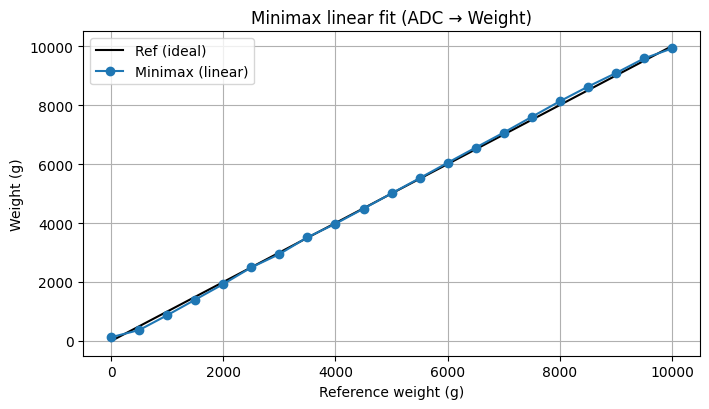

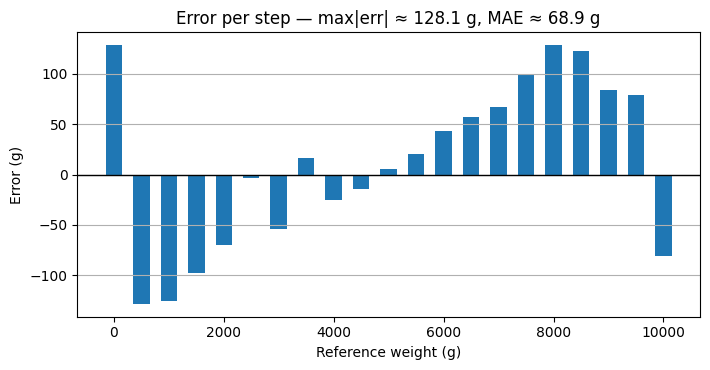

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# ----------------------------
# ข้อมูลอ้างอิง (Ref) และผลจาก Simulink (W_sim)
# ----------------------------
ref = np.array([0,500,1000,1500,2000,2500,3000,3500,4000,4500,
                5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000], float)

wsim = np.array([291.866834,526.559792,1010.68307,1518.788112,2026.91188,
                 2571.445234,3004.421564,3553.598966,3995.10811,4486.184976,
                 4986.562422,5482.302062,5985.769298,6480.728688,6971.025304,
                 7483.799362,7992.697138,8468.287602,8912.886536,9389.251008,9716.893588], float)

adc = np.array([122.354,197.552,352.67,515.472,678.28,852.754,991.484,1167.446,
                1308.91,1466.256,1626.582,1785.422,1946.738,2105.328,2262.424,
                2426.722,2589.778,2742.162,2884.616,3037.248,3142.228], float)

# ----------------------------
# ฟังก์ชันช่วย: minimax affine fit   y ≈ α x + β  (ลด max|error|)
# ----------------------------
def minimax_affine(x, y):
    n = len(y)
    # ตัวแปร [alpha, beta, t], minimize t
    c = np.array([0.0, 0.0, 1.0])
    A_ub = np.zeros((2*n, 3))
    b_ub = np.zeros(2*n)
    for i, (xi, yi) in enumerate(zip(x, y)):
        # alpha*xi + beta - t <= yi
        A_ub[2*i]   = [ xi,  1.0, -1.0]; b_ub[2*i]   = yi
        # -alpha*xi - beta - t <= -yi
        A_ub[2*i+1] = [-xi, -1.0, -1.0]; b_ub[2*i+1] = -yi
    # bounds: alpha, beta free; t >= 0
    bounds = [(None, None), (None, None), (0, None)]
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"Minimax optimization failed: {res.message}")
    alpha, beta, t = res.x
    pred = alpha * x + beta
    err  = pred - y
    stats = {
        "alpha": alpha, "beta": beta, "t_max_abs": t,
        "MAE": np.mean(np.abs(err)), "max_abs_err": np.max(np.abs(err)),
        "pred": pred, "err": err
    }
    return stats

# ----------------------------
# 1) Minimax บนผล Simulink (W_sim)
# ----------------------------
mm_sim = minimax_affine(wsim, ref)
print(f"[Minimax on W_sim]  W_corr = {mm_sim['alpha']:.10f} * W_sim + {mm_sim['beta']:.10f}")
print(f"  max|error| ≈ {mm_sim['t_max_abs']:.3f} g ;  MAE ≈ {mm_sim['MAE']:.3f} g")

# แปลงกลับเป็นสมการจาก ADC โดยตรง (เพราะ W_sim = 3.121*ADC - 90.3)
A_from_adc = 3.121 * mm_sim['alpha']
B_from_adc = mm_sim['beta'] - 90.3 * mm_sim['alpha']
print(f"[ADC→Weight (from W_sim)]  W = {A_from_adc:.10f} * ADC + {B_from_adc:.10f}")

# ----------------------------
# 2) Minimax จาก ADC → Ref โดยตรง
# ----------------------------
mm_adc = minimax_affine(adc, ref)
print(f"[Minimax on ADC]     W = {mm_adc['alpha']:.10f} * ADC + {mm_adc['beta']:.10f}")
print(f"  max|error| ≈ {mm_adc['t_max_abs']:.3f} g ;  MAE ≈ {mm_adc['MAE']:.3f} g")

# ----------------------------
# กราฟเปรียบเทียบ (ใช้ผลจากแบบ ADC โดยตรง)
# ----------------------------
pred = mm_adc["pred"]; err = mm_adc["err"]

plt.figure(figsize=(7.2,4.2))
plt.plot(ref, ref, 'k-', label='Ref (ideal)')
plt.plot(ref, pred, 'o-', label='Minimax (linear)')
plt.xlabel("Reference weight (g)"); plt.ylabel("Weight (g)")
plt.title("Minimax linear fit (ADC → Weight)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7.2,3.8))
plt.bar(ref, err, width=300)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel("Reference weight (g)"); plt.ylabel("Error (g)")
plt.title(f"Error per step — max|err| ≈ {mm_adc['t_max_abs']:.1f} g, MAE ≈ {mm_adc['MAE']:.1f} g")
plt.grid(True, axis='y'); plt.tight_layout(); plt.show()
